# Compare human hippo AD vs WT

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(patchwork)
    library(ggplot2)
    library(repr)
    library(gridExtra)
    library(edgeR)
    library(SingleCellExperiment)
    library(Matrix)
    library(scran)
    library(tidyverse)
    library(ggrepel)
    library(scater)
})
options(future.globals.maxSize = 1e9)
options(Seurat.object.assay.version = "v5")
options(ggrepel.max.overlaps = Inf)

In [2]:
setwd("~/5XFAD_mouse/data/")

In [3]:
seurat_object <- readRDS(
    "humanAD_objects/humanAD_seurat_merged_labeled_doublet_cluster_filtered_final.rds")

In [4]:
unique(seurat_object$donor)

[1] "hc1153"   "hc1203"   "hc69984"  "hc1216"   "hc98"     "hc12"    
 [7] "hc11"     "hc73"     "hc19"     "hc26"     "hc40"     "hc212191"
[13] "hc35"     "hc9"      "hp30"     "hp32"     "hp18"     "ad671"   
[19] "ad1551"   "ad13"     "ad22"     "ad24"

In [5]:
unique(seurat_object$group)

[1] Normal HP     AD    
Levels: Normal HP AD

In [6]:
human_object <- subset(seurat_object, subset = group %in% c("AD", "Normal"))
human_object <- human_object[!grepl("^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA", rownames(human_object)), ]
human_object <- human_object[!grepl("^MT-", rownames(human_object)), ]

[1] "Oligo"


Removing 3915 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "OPC"


Removing 7150 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "Micro"


Removing 9212 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



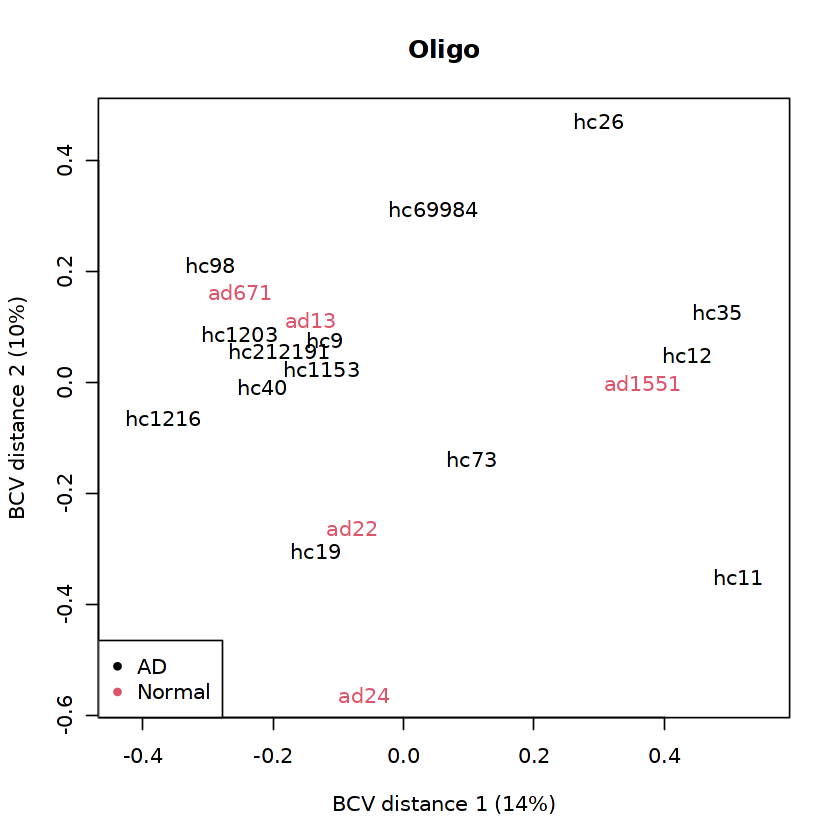

[1] "Astro"


Removing 6779 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



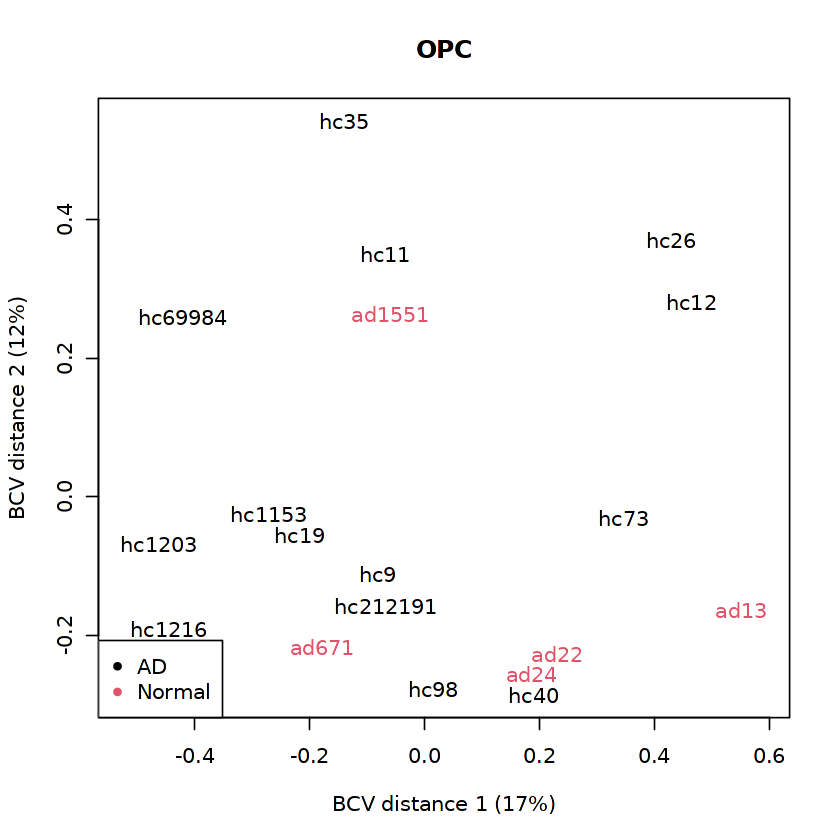

[1] "DG"


Removing 11585 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



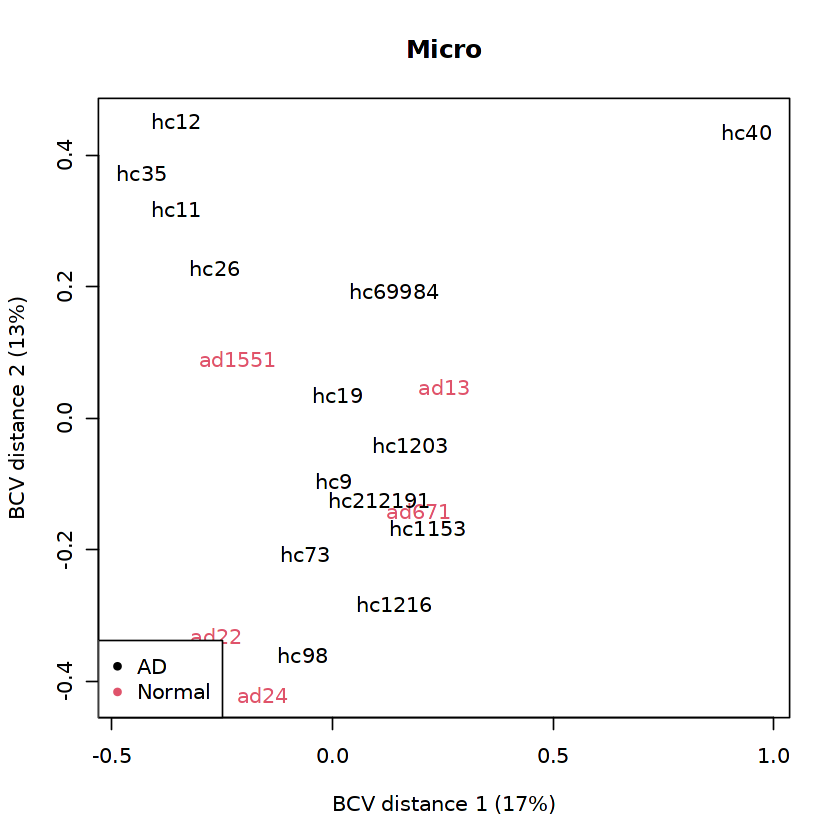

[1] "PVALB"


Removing 8274 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



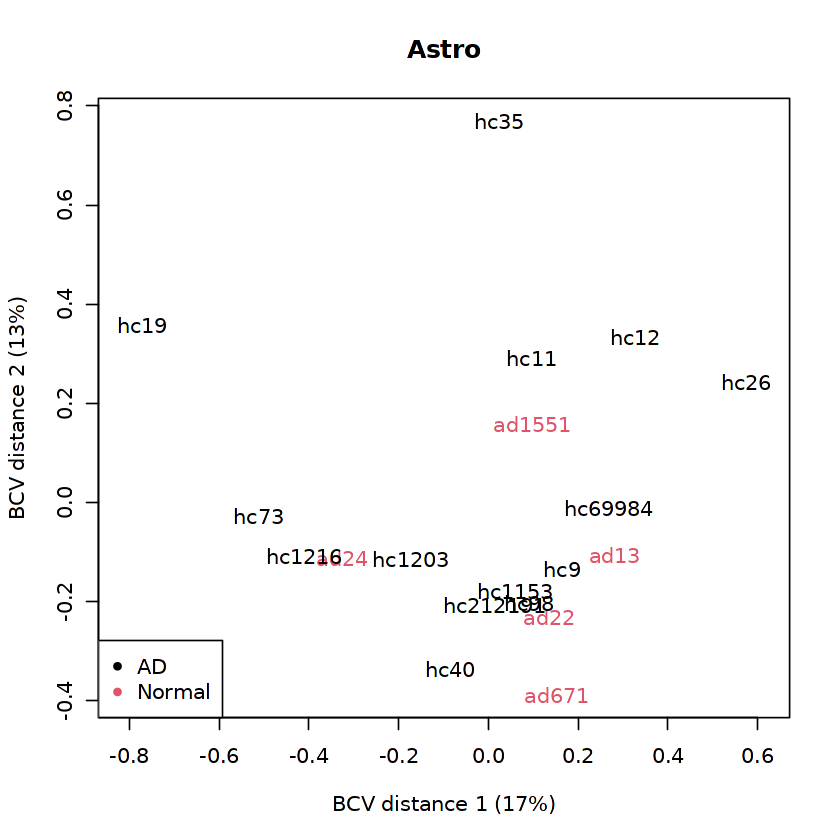

[1] "VIP"


Removing 7597 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



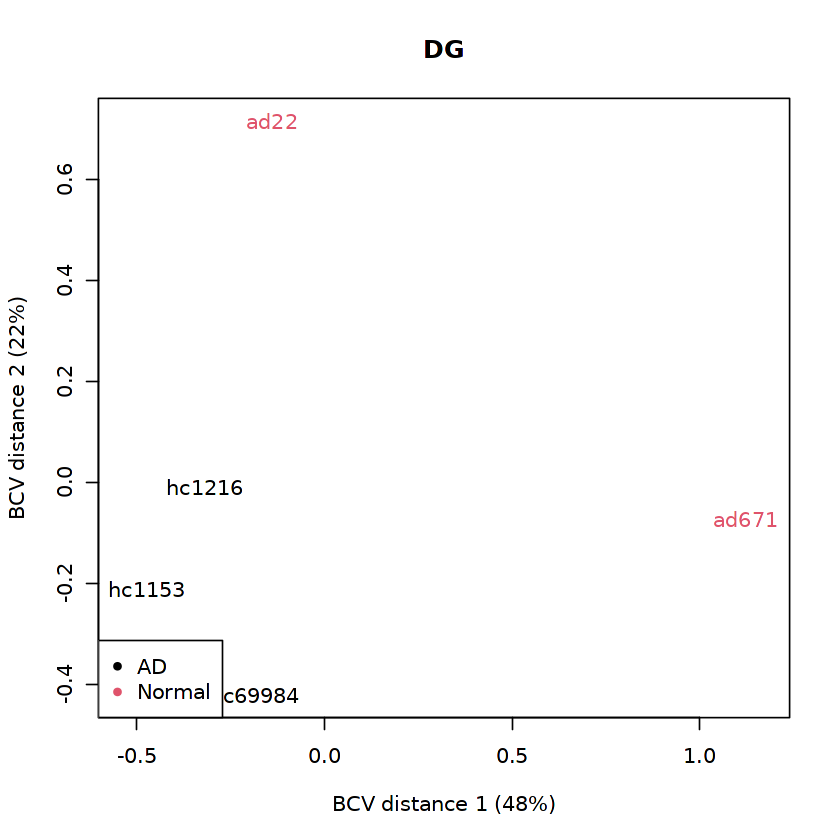

[1] "SUB"


Removing 3923 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



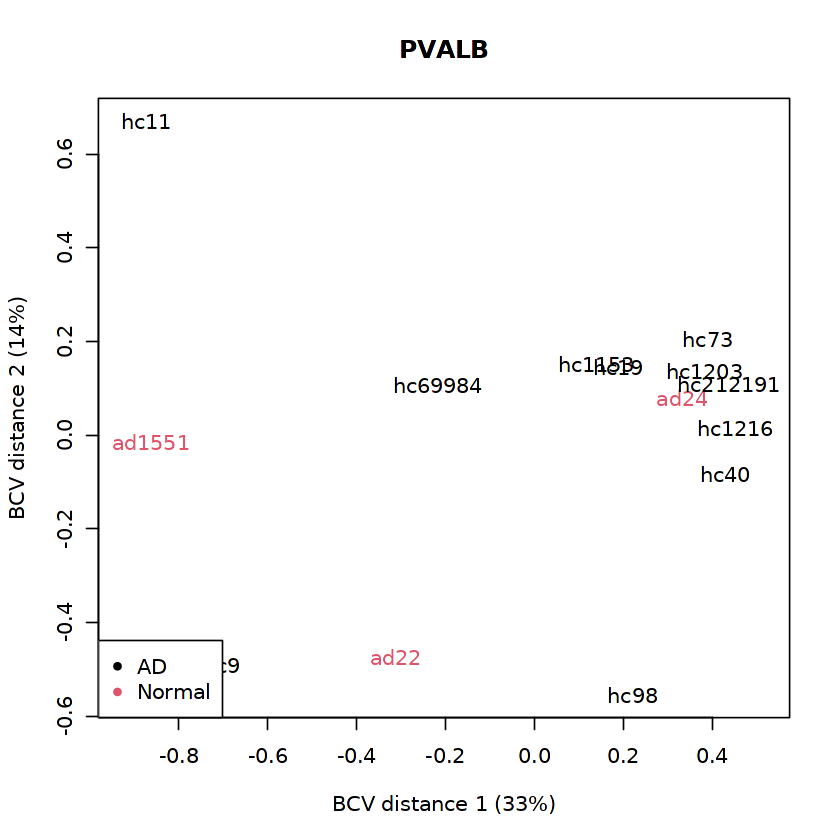

[1] "SST"


Removing 9966 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



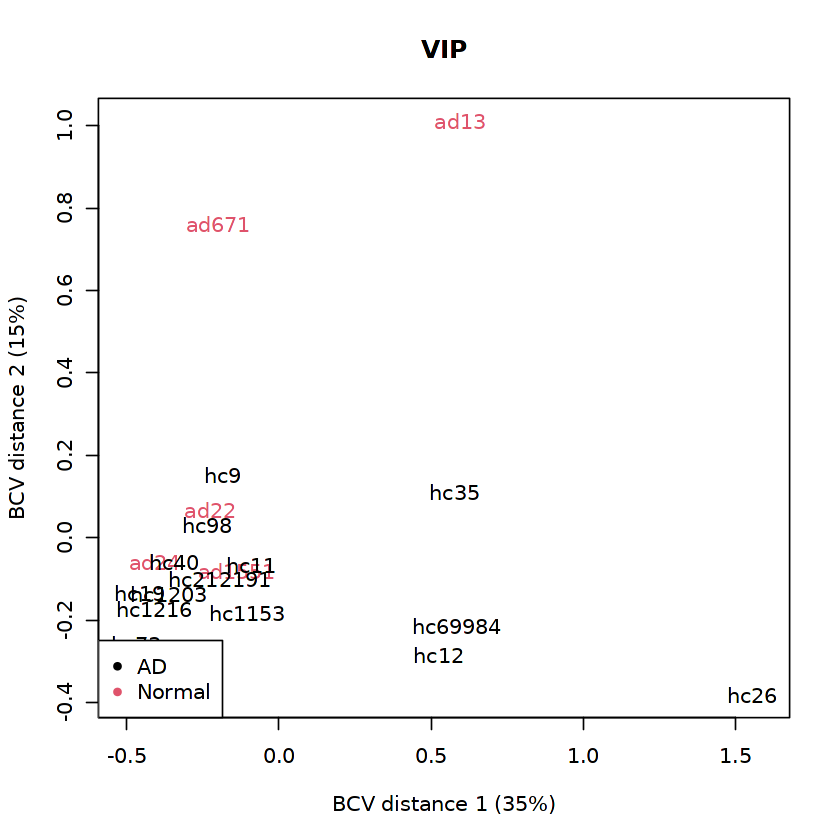

[1] "Macro"


Removing 18579 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



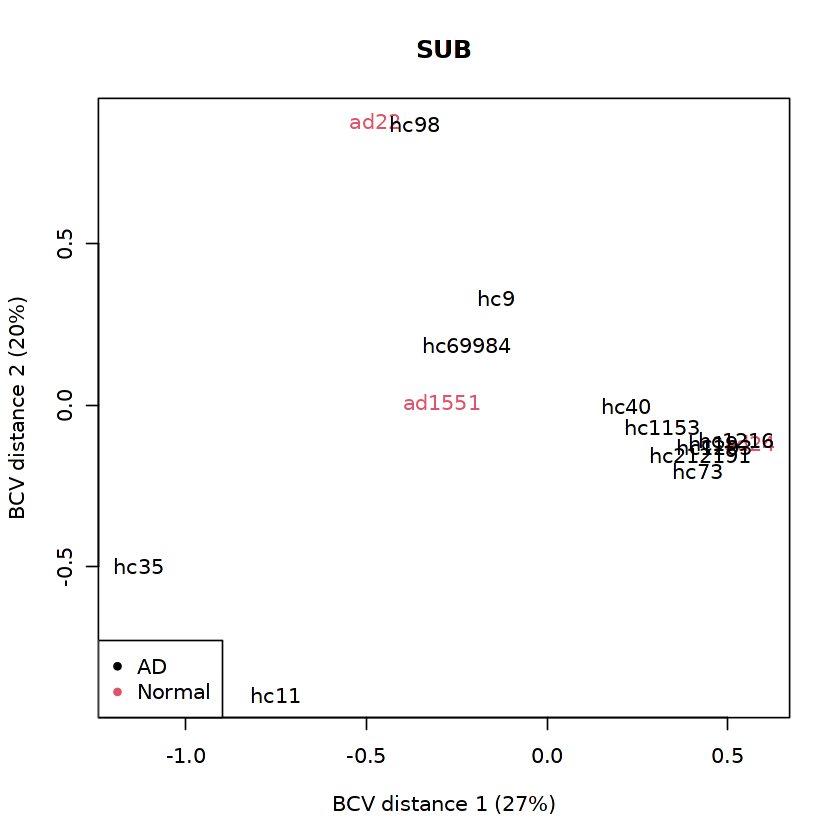

[1] "LAMP5"


Removing 9738 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



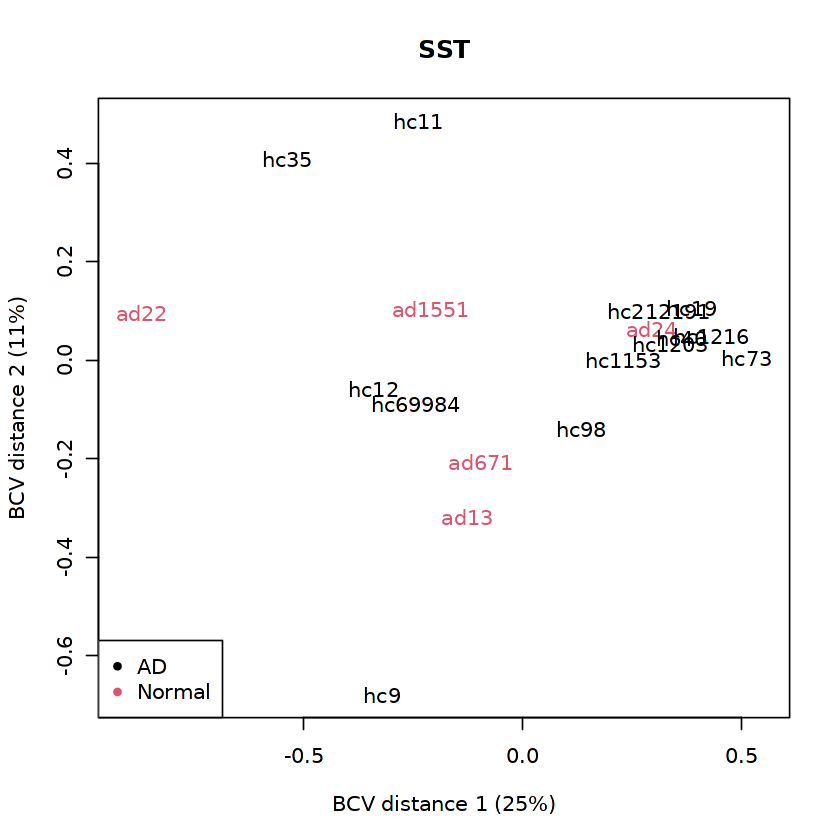

[1] "NR2F2"


Removing 9543 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



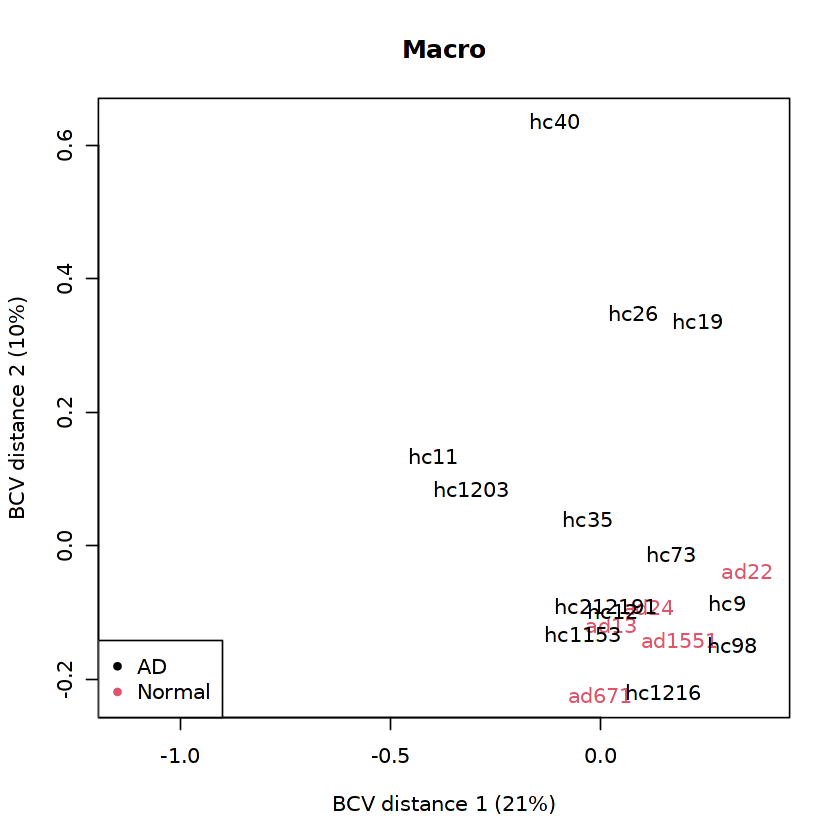

[1] "CA"


Removing 9011 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



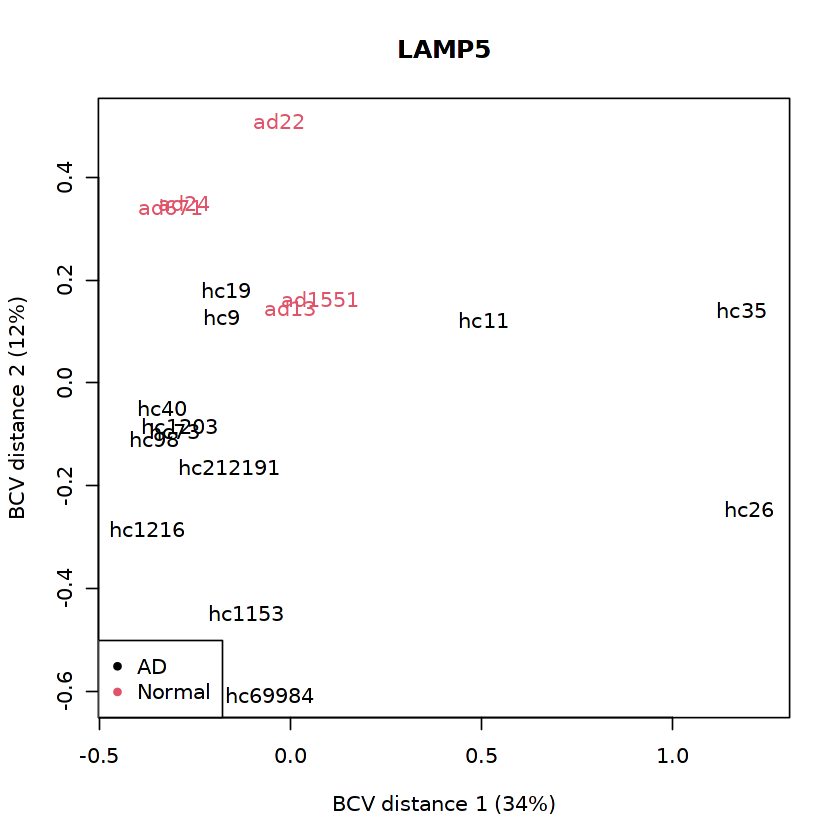

[1] "Endo_VLMC"


Removing 18683 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



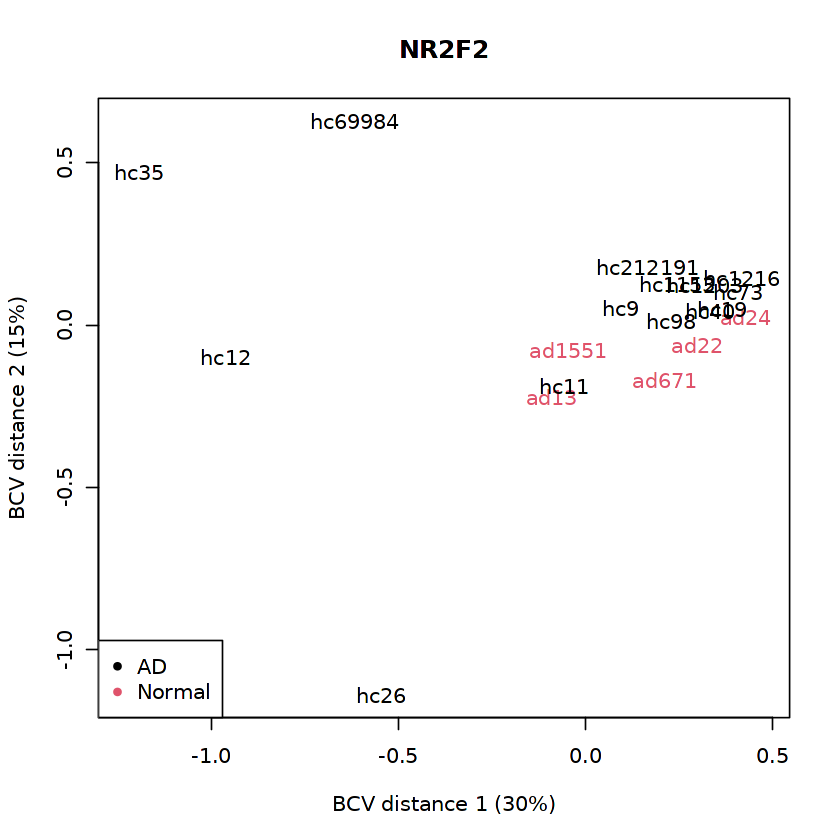

[1] "Chandelier"


Removing 14329 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



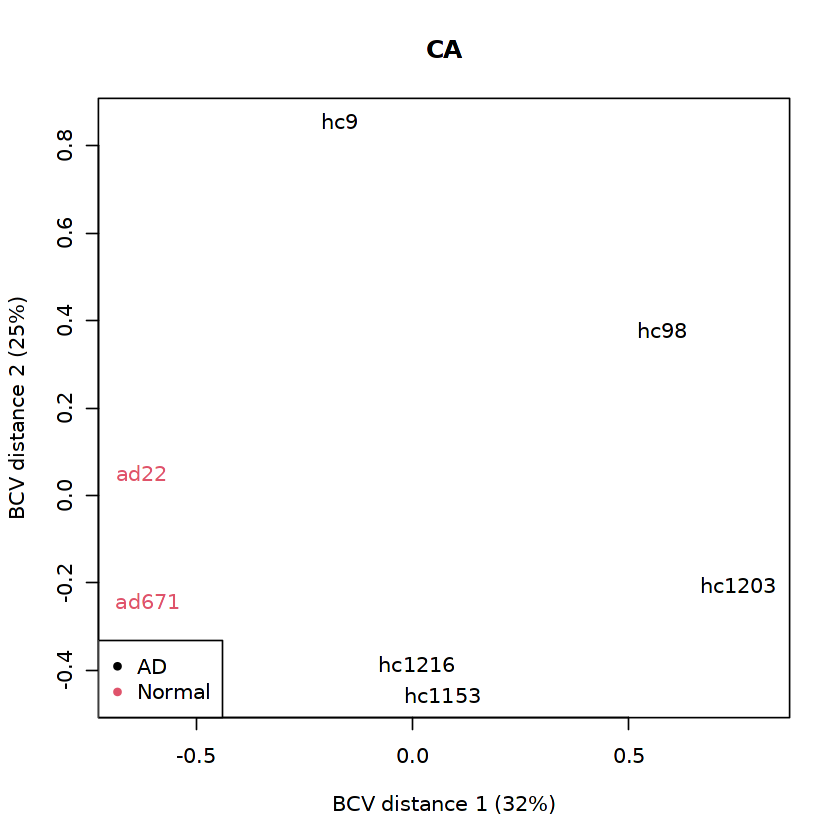

[1] "T-Cell"


Removing 21396 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



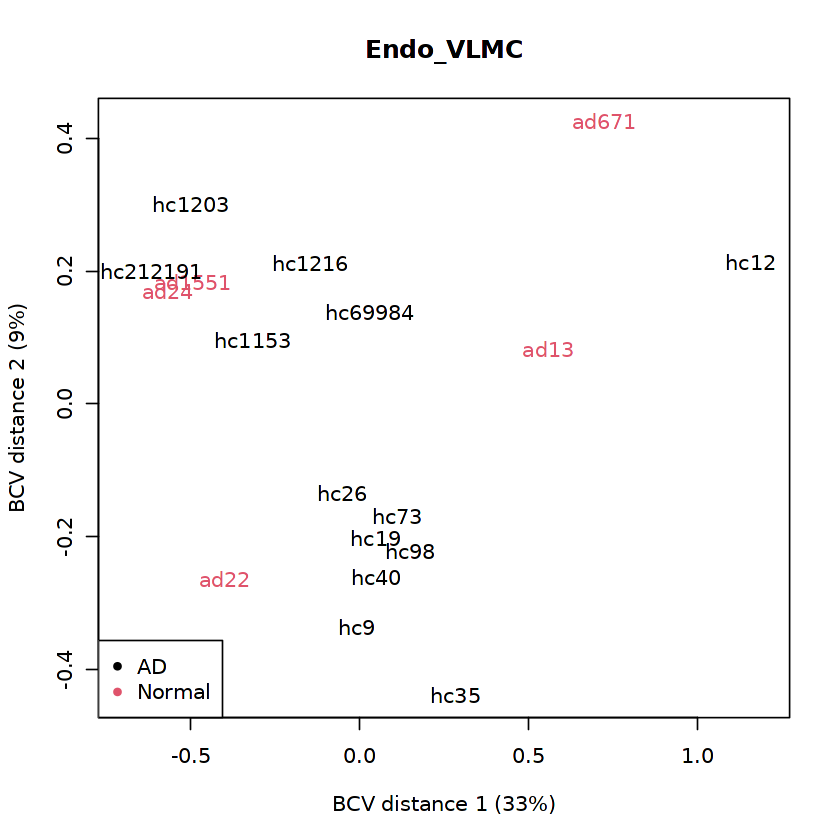

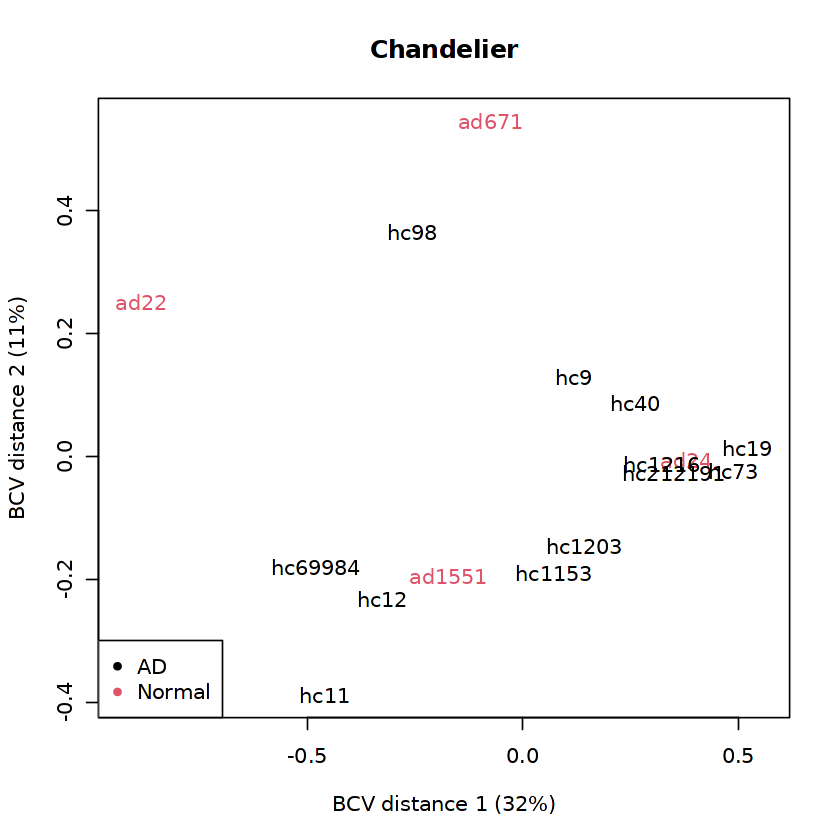

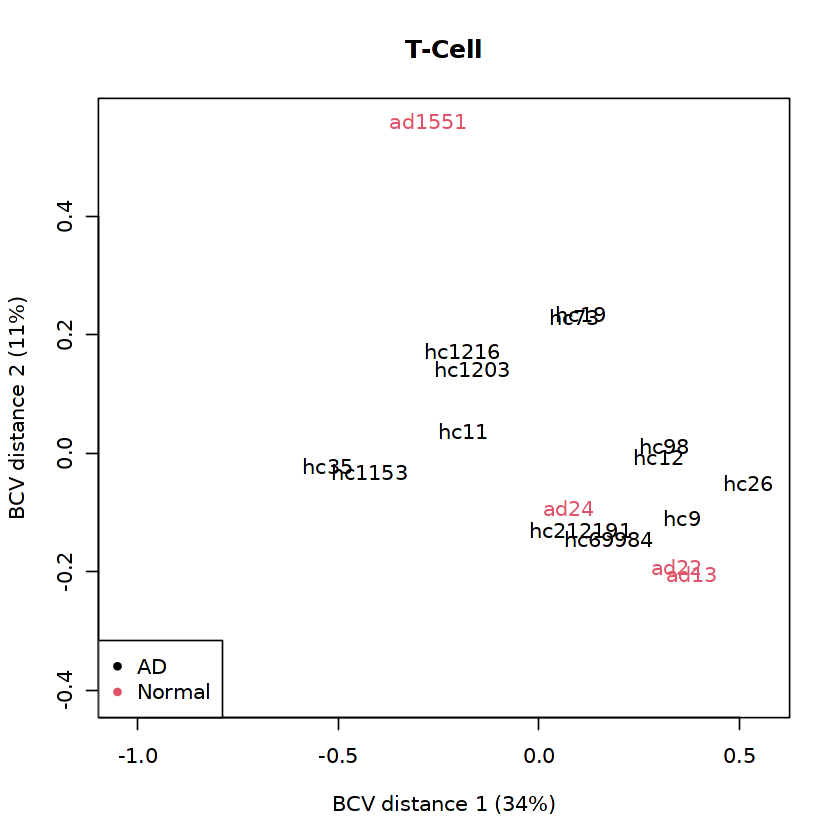

In [7]:
for (cluster in unique(human_object$final_celltype)) {
    suppressPackageStartupMessages({
        library(scran)
        library(scater)
    })
    print(cluster)
    flush.console()
    curr_object <- human_object[, human_object$final_celltype == cluster]
    if (ncol(curr_object) < 10) {
        next
    }
    curr_counts <- LayerData(curr_object, layer = c("counts"))
    curr_meta <- curr_object@meta.data
    curr_sce <- SingleCellExperiment(assays = list(counts = curr_counts), colData = curr_meta)
    curr_sce$group <- factor(curr_sce$group, levels = c("Normal", "AD"))
    groups <- curr_sce$donor
    if (length(unique(groups)) < 2) {
        next
    }
    curr_aggr <- aggregateAcrossCells(curr_sce, groups, store.number = "group.size")
    
    curr_dge <- DGEList(counts = counts(curr_aggr), group = curr_aggr$group, remove.zeros = TRUE)
    keep <- filterByExpr(curr_dge, min.count = 5, min.prop = 0.5)
    curr_dge <- curr_dge[keep, , keep.lib.sizes=FALSE]
    curr_dge <- calcNormFactors(curr_dge, method = "TMM")
    
    detach("package:scran", unload = TRUE)
    detach("package:scater", unload = TRUE)
    plotMDS(curr_dge, method="bcv", col=as.numeric(curr_dge$samples$group))
    legend("bottomleft", as.character(unique(curr_dge$samples$group)), col=1:2, pch=20)
    title(main = cluster)
    
    curr_design <- model.matrix(~ 0 + curr_aggr$group)
    colnames(curr_design) <- levels(curr_aggr$group)
    curr_dge <- estimateDisp(curr_dge, curr_design, robust = TRUE)
    curr_fit <- glmQLFit(curr_dge, curr_design)
    curr_glf <- glmQLFTest(curr_fit, contrast = c(-1, 1))
    
    write.table(
        topTags(curr_glf, n = Inf)$table, 
        file.path("DGE_humanAD/", paste0(cluster, ".result.tsv")), 
        row.names = TRUE,
        col.names = TRUE,
        quote = FALSE,
        sep = "\t"
    )
}

## Jeff's notebook

In [7]:
se_object <- readRDS("human_hippo_old_normal_ad_hp_231227.rds")

In [8]:
se_object <- se_object[!grepl("^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA", rownames(se_object)), ]
se_object <- se_object[!grepl("^MT-", rownames(se_object)), ]

In [9]:
micro_obj <- subset(se_object, subset = celltype == "Microglia")

In [10]:
micro_obj[["RNA"]] <- JoinLayers(micro_obj[["RNA"]], layers = c("counts", "data"))

In [11]:
micro_obj <- micro_obj[, !(micro_obj$orig.ident %in% c("hp18","hp30","hp32"))]

In [12]:
micro_counts <- LayerData(micro_obj, layer = c("counts"))
micro_sce <- SingleCellExperiment(
    assays = list(counts = micro_counts),
    colData = micro_obj@meta.data
)

In [13]:
unique(micro_sce$pathology)

[1] "normal" "AD"

In [14]:
micro_sce$pathology <- factor(micro_sce$pathology, levels = c("normal", "AD"))
micro_aggr <- aggregateAcrossCells(micro_sce, micro_sce$orig.ident, store.number = "group.size")

In [15]:
d <- DGEList(counts = counts(micro_aggr), group = factor(micro_aggr$dataset))

In [16]:
d

,ad13,ad22,ad22_nz,ad22_qz,ad24,hc11,hc12,hc19,hc212191,hc26,hc35,hc40,hc73,hc9,hc98
AL627309.1,5,3,21,7,17,31,13,3,0,8,27,3,2,7,9
AL627309.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AL627309.5,5,3,28,16,16,29,16,11,5,35,52,6,8,35,40
LINC01409,34,9,60,20,33,16,11,13,16,15,39,59,47,30,82
LINC01128,15,3,27,11,14,30,9,12,5,43,21,58,12,11,47
LINC00115,4,0,0,0,2,1,3,2,1,8,3,5,9,3,15
FAM41C,3,4,10,3,5,8,7,3,2,3,8,6,2,4,6
AL645608.6,0,0,0,1,0,0,0,0,0,0,3,1,0,0,0
AL645608.2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
LINC02593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
keep <- rowSums(edgeR::cpm(d)>10) >= 2
d_f <- d[keep,]
dim(d_f)

[1] 11820    15

In [18]:
d_f$samples$lib.size <- colSums(d_f$counts)
d_f$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
ad13,ad_hp,1106687,1
ad22,ad_hp,463905,1
ad22_nz,ad_hp,2157808,1
ad22_qz,ad_hp,1019145,1
ad24,ad_hp,1381027,1
hc11,normal,833614,1
hc12,normal,692296,1
hc19,normal,471932,1
hc212191,normal,304309,1


In [19]:
d <- calcNormFactors(d)
d_f <- calcNormFactors(d_f)

In [20]:
detach("package:scran", unload = TRUE)
detach("package:scater", unload = TRUE)

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



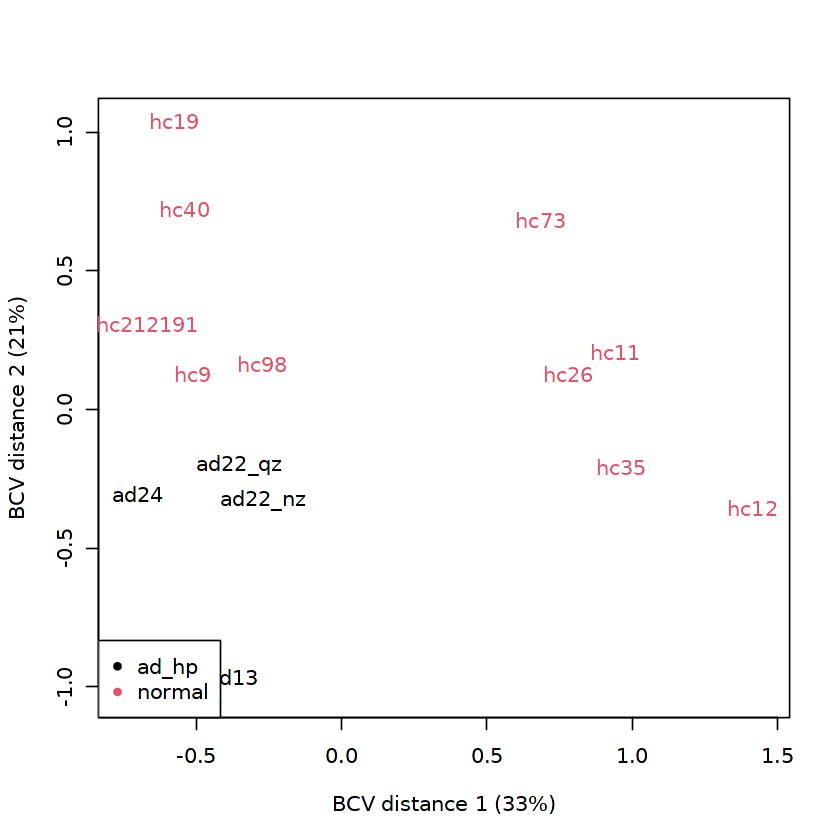

In [21]:
plotMDS(d, method="bcv", col=as.numeric(d$samples$group))
legend("bottomleft", as.character(unique(d$samples$group)), col=1:2,pch=20)

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



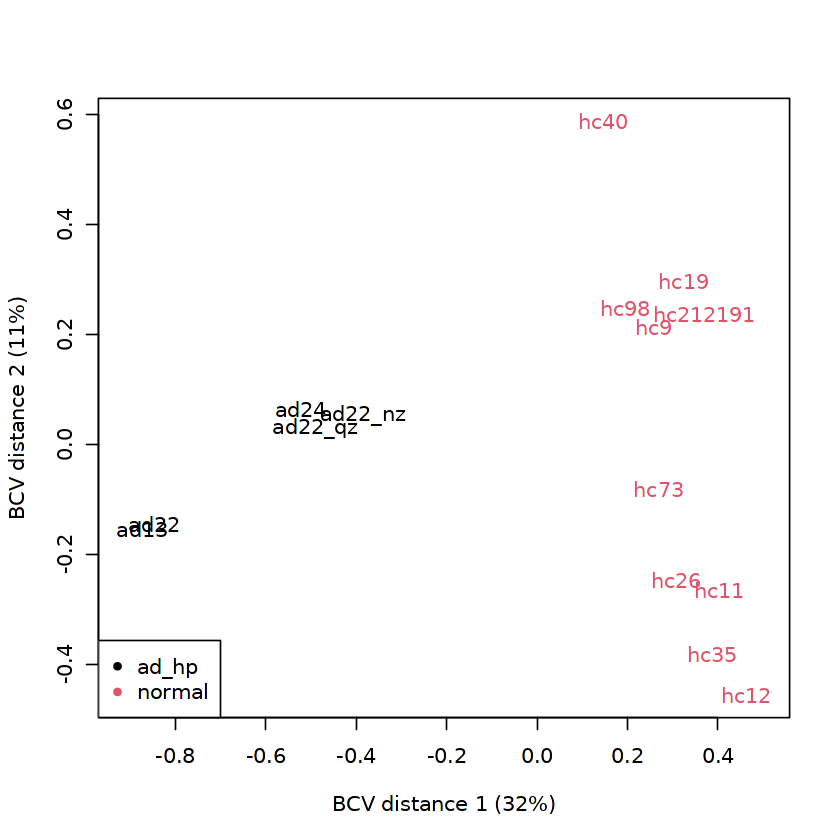

In [22]:
plotMDS(d_f, method="bcv", col=as.numeric(d_f$samples$group))
legend("bottomleft", as.character(unique(d_f$samples$group)), col=1:2,pch=20)

In [23]:
design <- model.matrix(~ 0 + factor(micro_aggr$dataset), data = d_f$samples)
colnames(design) <- levels(factor(micro_aggr$dataset))

In [24]:
d_f <- estimateDisp(d_f, design, robust=TRUE)
d_f$common.dispersion

[1] 0.202027

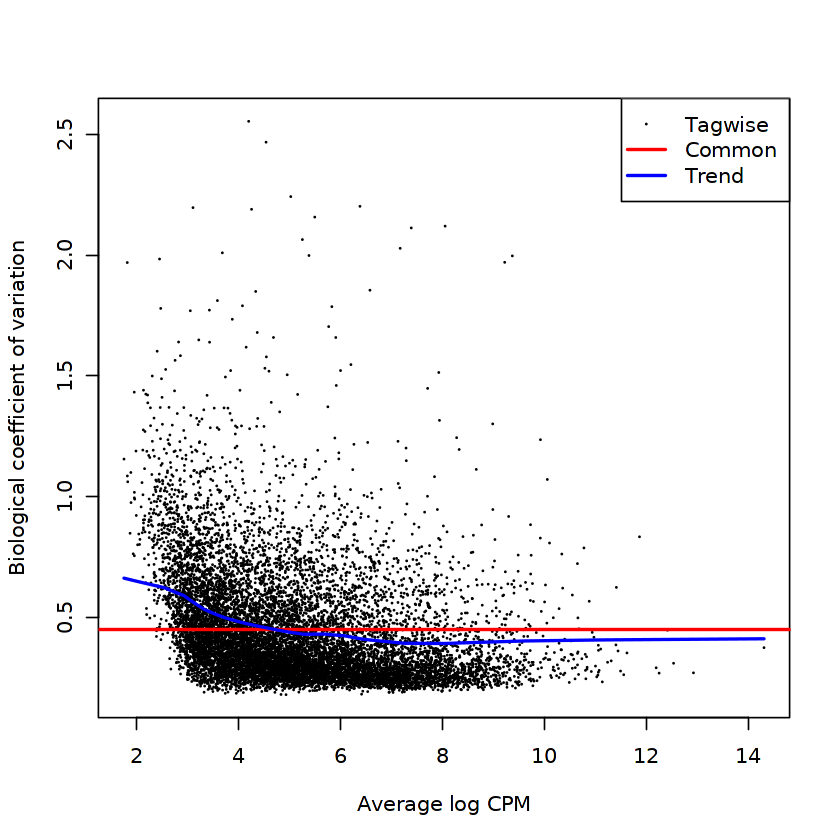

In [25]:
plotBCV(d_f)

In [26]:
fit <- glmQLFit(d_f, design)
qlf.1vs2 <- glmQLFTest(fit, contrast=c(1,-1))

In [27]:
top <- rownames(topTags(qlf.1vs2, n=50))

In [28]:
edgeR::cpm(d_f)[top,]

,ad13,ad22,ad22_nz,ad22_qz,ad24,hc11,hc12,hc19,hc212191,hc26,hc35,hc40,hc73,hc9,hc98
PEX5L,1394.7103,1022.29883,140.31540,171.40313,204.99764,6.779996,14.305440,12.107213,14.902355,10.4136911,11.3792278,6.168321,10.6129057,15.295704,9.7383594
NLGN1,1236.3918,967.15408,155.17747,204.14305,257.71132,5.649997,12.874896,6.053607,17.882825,7.8102683,8.9836009,6.168321,27.0146690,15.295704,8.1676563
IL1RAPL1,6641.8366,3281.11265,380.73119,625.91030,808.27641,32.769981,44.346865,48.428853,32.785180,43.3903794,46.1158181,41.636165,34.7331458,53.534964,30.1575001
AK5,514.5350,311.77993,64.69370,71.25748,98.91950,5.649997,5.722176,6.053607,8.941413,2.6034228,2.3956269,6.168321,7.7184768,5.735889,6.2828125
GPM6B,994.2023,907.76743,152.11763,446.80366,251.85424,25.989985,45.777409,26.232295,29.804709,58.1431085,20.3628288,32.383684,22.1906209,28.679445,33.2989064
NKAIN2,1893.2250,901.40457,149.05779,236.88297,342.31352,5.649997,10.013808,8.071476,17.882825,17.3561518,10.7803211,10.794561,23.1554305,24.855519,16.0211719
CDH20,911.2735,504.78656,81.30425,105.92328,100.22107,7.909995,7.152720,8.071476,0.000000,6.0746531,5.9890673,4.626241,2.8944288,5.735889,2.8272656
AMER2,336.4267,277.84470,50.26876,81.84981,66.38019,9.039995,14.305440,8.071476,5.960942,6.9424607,4.1923471,7.710401,4.8240480,5.735889,5.3403906
NCAM2,2910.9865,2142.16146,326.52836,389.02732,553.81902,18.079989,37.194145,32.285902,11.921884,28.6376504,21.5606422,10.794561,32.8035266,65.006742,15.0787501
PTPRK,1102.5750,890.79981,114.08822,125.18206,143.82374,5.649997,2.861088,10.089344,11.921884,9.5458835,11.3792278,4.626241,9.6480961,14.339723,4.0838281


In [29]:
counts(micro_aggr["PEX5L", ])

,ad13,ad22,ad22_nz,ad22_qz,ad24,hc11,hc12,hc19,hc212191,hc26,hc35,hc40,hc73,hc9,hc98
PEX5L,1480,482,321,178,315,6,10,6,5,12,19,4,11,16,31


## Seoyeon data

In [30]:
syl_object <- human_object[!grepl("^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA", rownames(human_object)), ]
syl_object <- syl_object[!grepl("^MT-", rownames(syl_object)), ]

In [31]:
syl_object

An object of class Seurat 
72970 features across 85523 samples within 2 assays 
Active assay: RNA (36485 features, 1990 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: sketch
 5 dimensional reductions calculated: pca, umap, pca.full, full.umap, full.umap.1

In [32]:
syl_micro <- syl_object[, syl_object$predicted.id.human == "Microglia"]
syl_micro <- syl_micro[, syl_micro$group %in% c("Normal", "AD")]

In [33]:
suppressPackageStartupMessages({
    library(scran)
    library(scater)
})

In [34]:
syl_micro_counts <- LayerData(syl_micro, layer = c("counts"))
syl_micro_sce <- SingleCellExperiment(
    assays = list(counts = syl_micro_counts),
    colData = syl_micro@meta.data
)

In [35]:
syl_micro_aggr <- aggregateAcrossCells(
    syl_micro_sce, syl_micro_sce$donor, store.number = "group.size")

In [36]:
top

[1] "PEX5L"     "NLGN1"     "IL1RAPL1"  "AK5"       "GPM6B"     "NKAIN2"   
 [7] "CDH20"     "AMER2"     "NCAM2"     "PTPRK"     "SLC24A2"   "NCAM1"    
[13] "LSAMP"     "PCDH9"     "MAGI2"     "SPOCK3"    "ADGRL3"    "CACNA2D1" 
[19] "QDPR"      "TTLL7"     "PTPRD"     "SPOCK1"    "EDIL3"     "GRM3"     
[25] "DNAJC6"    "ENOX1"     "NOVA1"     "FBXL7"     "PPP2R2B"   "CTNND2"   
[31] "PHYHIPL"   "ZNF536"    "GALNT13"   "PPP1R9A"   "ITGB8"     "GPRC5B"   
[37] "C10orf90"  "NFIB"      "SLCO1A2"   "SGIP1"     "CADM2"     "DSCAML1"  
[43] "PHACTR3"   "TMEFF2"    "PPFIA2"    "FIGN"      "MAP7"      "CLMN"     
[49] "MDGA2"     "LINC01608"

In [37]:
counts(micro_aggr[top, ])

,ad13,ad22,ad22_nz,ad22_qz,ad24,hc11,hc12,hc19,hc212191,hc26,hc35,hc40,hc73,hc9,hc98
PEX5L,1480,482,321,178,315,6,10,6,5,12,19,4,11,16,31
NLGN1,1312,456,355,212,396,5,9,3,6,9,15,4,28,16,26
IL1RAPL1,7048,1547,871,650,1242,29,31,24,11,50,77,27,36,56,96
AK5,546,147,148,74,152,5,4,3,3,3,4,4,8,6,20
GPM6B,1055,428,348,464,387,23,32,13,10,67,34,21,23,30,106
NKAIN2,2009,425,341,246,526,5,7,4,6,20,18,7,24,26,51
CDH20,967,238,186,110,154,7,5,4,0,7,10,3,3,6,9
AMER2,357,131,115,85,102,8,10,4,2,8,7,5,5,6,17
NCAM2,3089,1010,747,404,851,16,26,16,4,33,36,7,34,68,48
PTPRK,1170,420,261,130,221,5,2,5,4,11,19,3,10,15,13


In [38]:
counts(syl_micro_aggr[top, ])

,ad13,ad1551,ad22,ad24,ad671,hc11,hc12,hc19,hc212191,hc26,hc40,hc73,hc9,hc98
PEX5L,3616,53,1808,857,208,125,1856,36,41,736,721,867,353,1459
NLGN1,3108,34,1695,1302,133,74,1685,42,24,516,1255,1078,384,2597
IL1RAPL1,16210,144,6198,3933,757,309,10888,229,237,4893,4472,4187,2505,10606
AK5,1159,22,633,357,52,35,637,17,11,167,291,334,111,714
GPM6B,2536,72,2675,847,156,77,2044,78,57,956,580,592,434,2085
NKAIN2,4818,49,2117,1312,323,62,2529,47,86,1569,1362,1171,940,3265
CDH20,2210,46,1010,587,69,44,1026,47,35,380,356,445,216,871
AMER2,765,14,725,232,33,25,502,22,12,247,226,150,111,582
NCAM2,7793,96,3891,2659,256,146,5013,158,69,1408,1332,1506,1254,4935
PTPRK,2956,29,1659,667,142,52,1964,72,40,968,754,815,450,2150


In [39]:
colSums(counts(micro_aggr))

ad13     ad22  ad22_nz  ad22_qz     ad24     hc11     hc12     hc19 
 1131546   473736  2196904  1035981  1411391   846483   700115   478417 
hc212191     hc26     hc35     hc40     hc73      hc9     hc98 
  310091  1380522  1744635   805590   991341  1120171  3184340

In [40]:
colSums(counts(syl_micro_aggr))

ad13   ad1551     ad22     ad24    ad671     hc11     hc12     hc19 
 2075411  1110248  3961232  1616356   547940   616611  1529390   437201 
hc212191     hc26     hc40     hc73      hc9     hc98 
  357900  1754494  1379781  1466928  1294440  4985413

In [41]:
tail(colnames(micro_sce))

[1] "ad24_TTTCAGTTCCGGCTAA-1" "ad24_TTTGCGACATTGGGAG-1"
[3] "ad24_TTTGGCTGTTGTTCAC-1" "ad24_TTTGGTAAGTCCTTCA-1"
[5] "ad24_TTTGTCTAGGAACCAA-1" "ad24_TTTGTGGCATAAGTCT-1"

In [42]:
tail(colnames(syl_micro_sce))

[1] "ad1551_TTTCCGGGTCATTGTC-1" "ad1551_TTTCCTGAGGTGTCCA-1"
[3] "ad1551_TTTGCATTCTTAGCCC-1" "ad1551_TTTGGTGCAGCATGGA-1"
[5] "ad1551_TTTGTCCCAGCATGTC-1" "ad1551_TTTGTGGCAGGACCAA-1"

In [43]:
unique(se_object$celltype)

[1] "OPC"        "Oligo"      "Astro"      "VIP"        "Macro"     
 [6] "Microglia"  "SST"        "PVALB"      "Chandelier" "NR2F2"     
[11] "LAMP5"      "SUB"        "T-Cell"     "VLMC"       "Endo"      
[16] "CA1"        "DG"         "CA2-CA3"

In [44]:
se_object <- readRDS("human_hippo_old_normal_ad_hp_231227.rds")
se_object[["RNA"]] <- JoinLayers(se_object[["RNA"]], layers = c("counts"))

In [45]:
se_object <- se_object[, !(se_object$orig.ident %in% c("hp18", "hp30", "hp32"))]

In [46]:
unique(se_object$dataset)

[1] "normal" "ad_hp"

In [47]:
unique(se_object$orig.ident)

[1] "hc11"     "hc12"     "hc19"     "hc212191" "hc26"     "hc35"    
 [7] "hc40"     "hc73"     "hc98"     "hc9"      "ad13"     "ad22"    
[13] "ad22_nz"  "ad22_qz"  "ad24"

[1] "OPC"


Removing 8052 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "Oligo"


Removing 5573 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "Astro"


Removing 7253 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



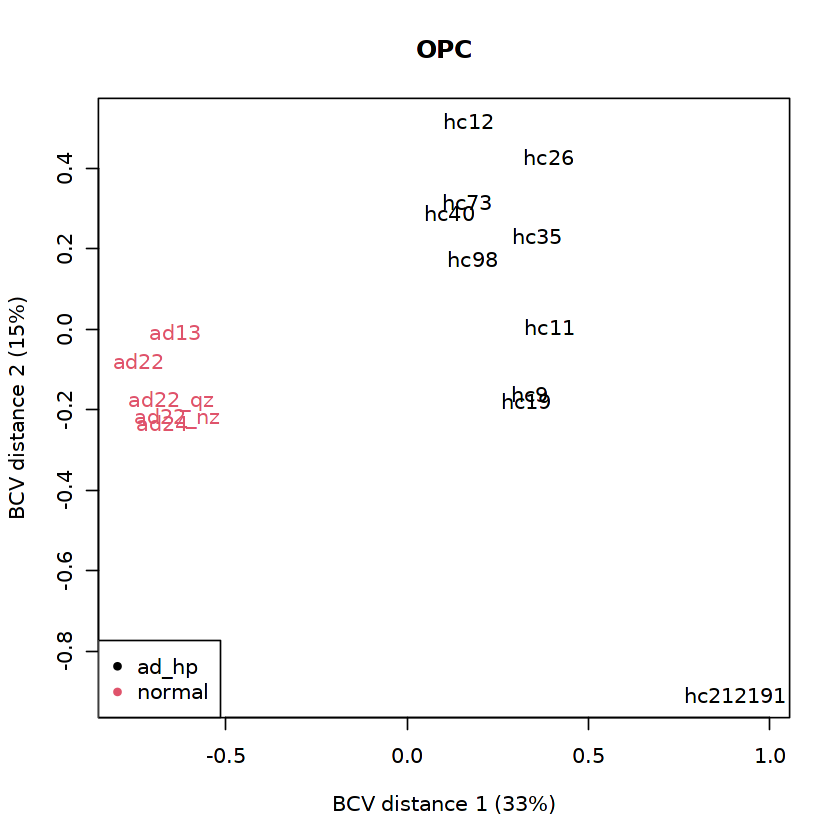

[1] "VIP"


Removing 7268 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



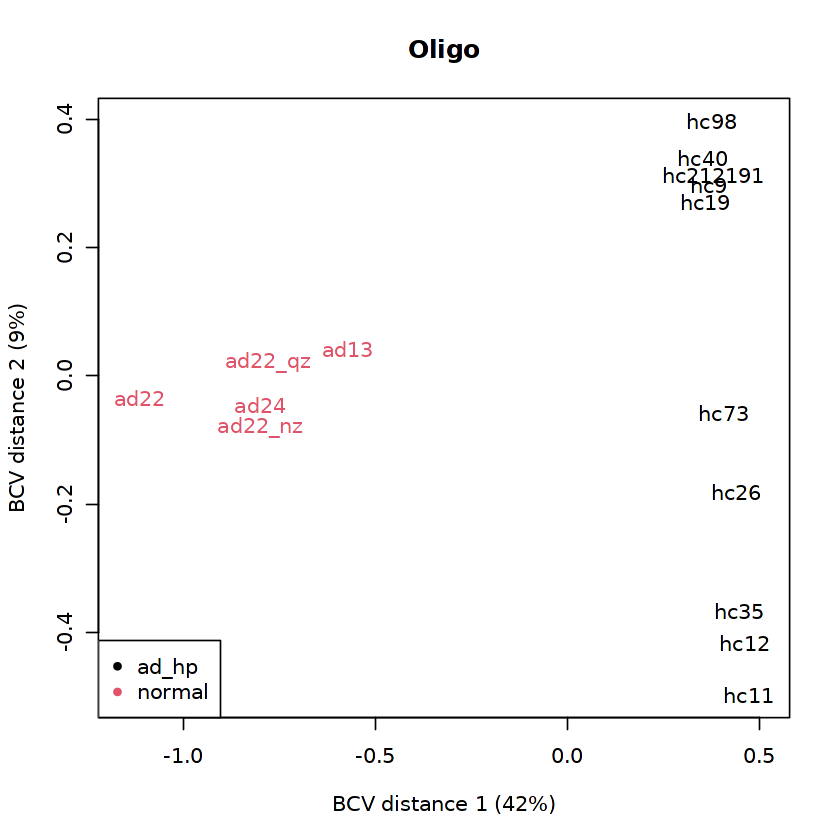

[1] "Macro"


Removing 16560 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



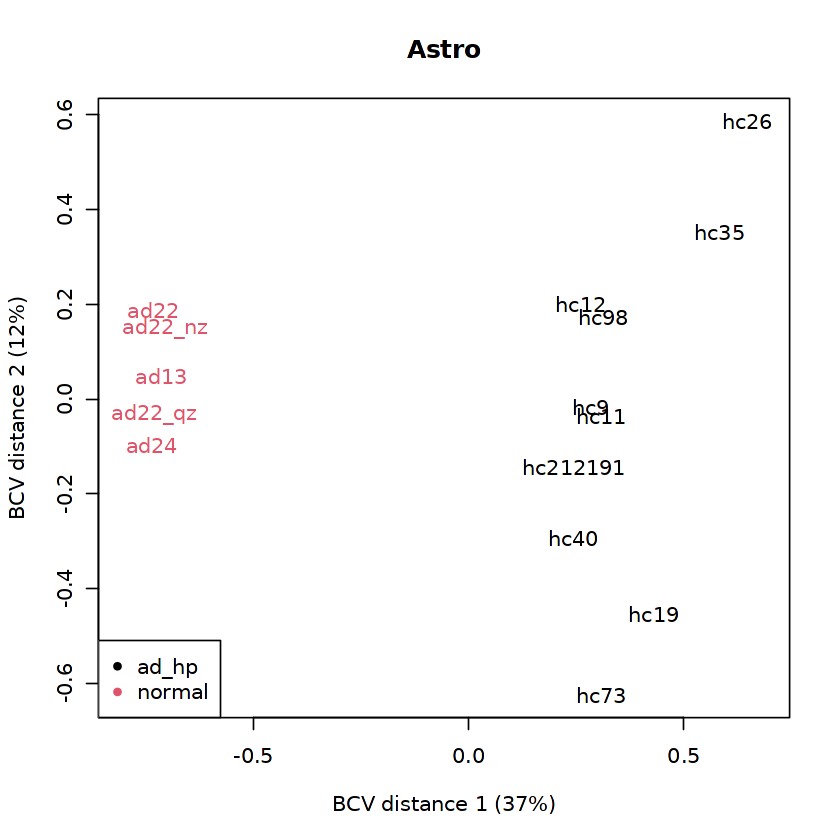

[1] "Microglia"


Removing 8966 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



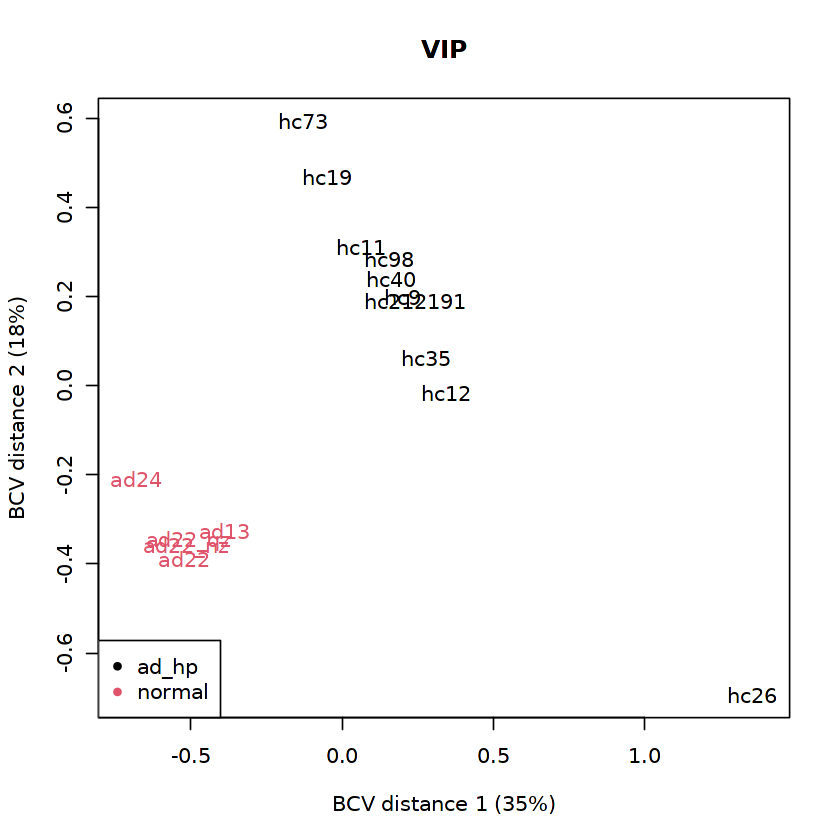

[1] "SST"


Removing 8750 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



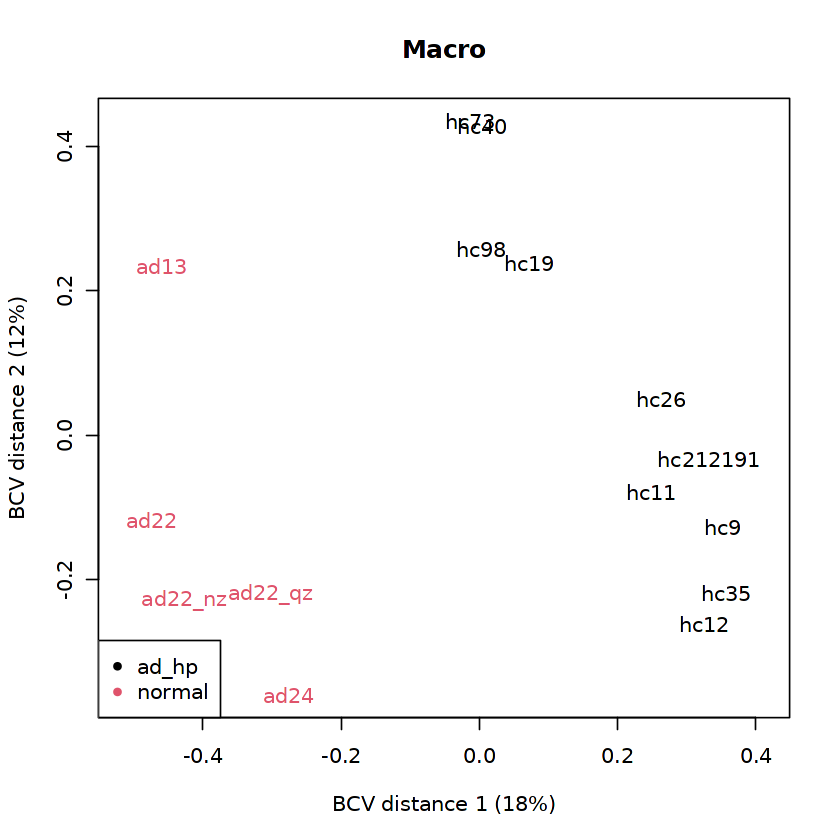

[1] "PVALB"


Removing 7837 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



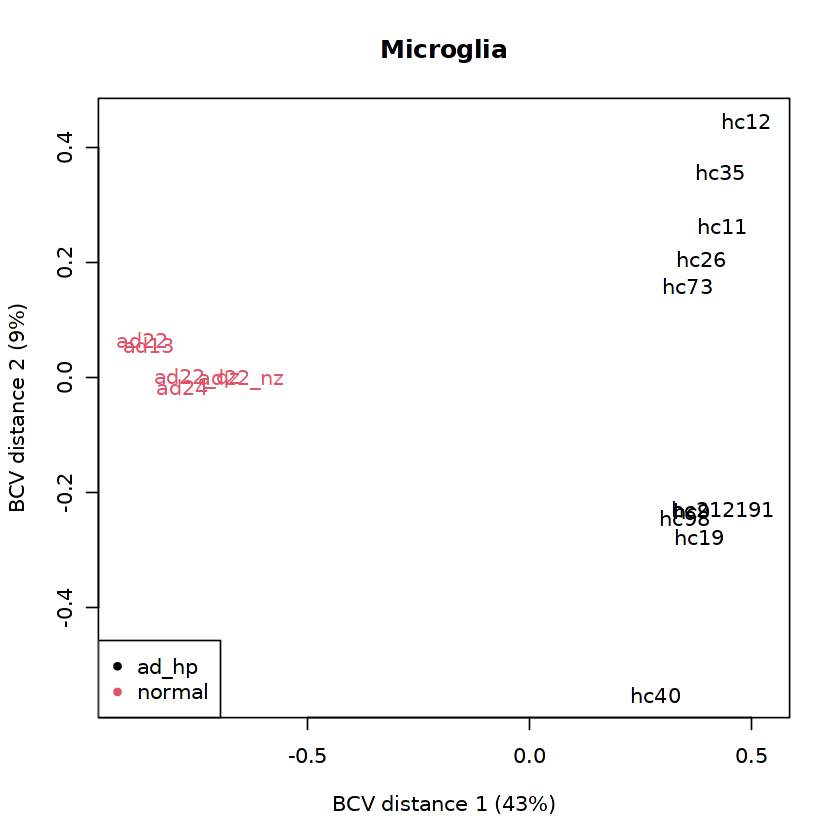

[1] "Chandelier"


Removing 13803 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



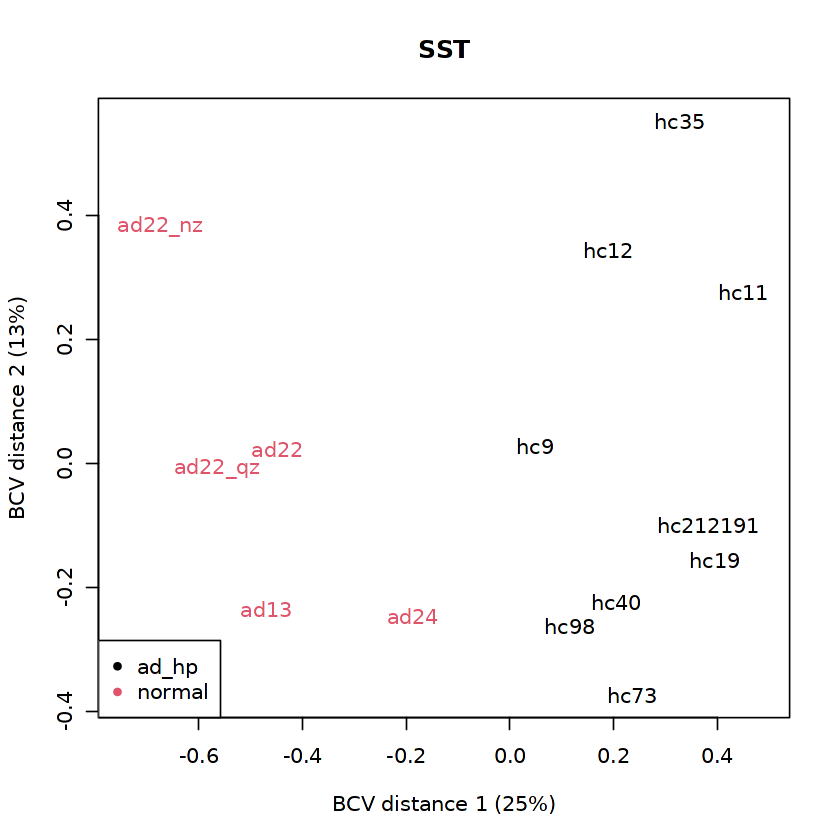

[1] "NR2F2"


Removing 7170 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



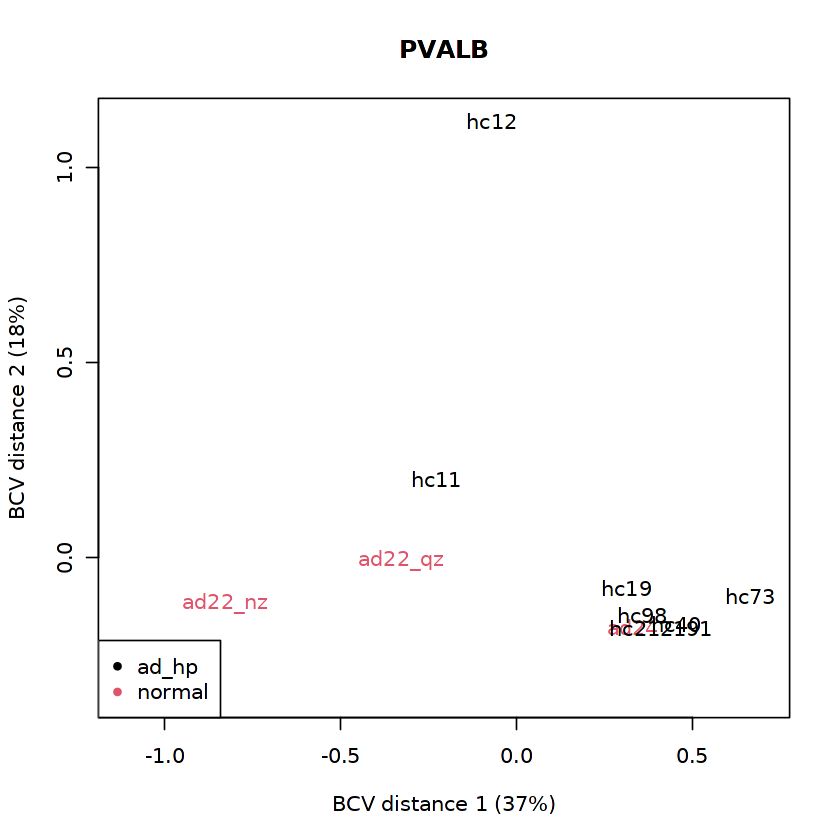

[1] "LAMP5"


Removing 8643 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



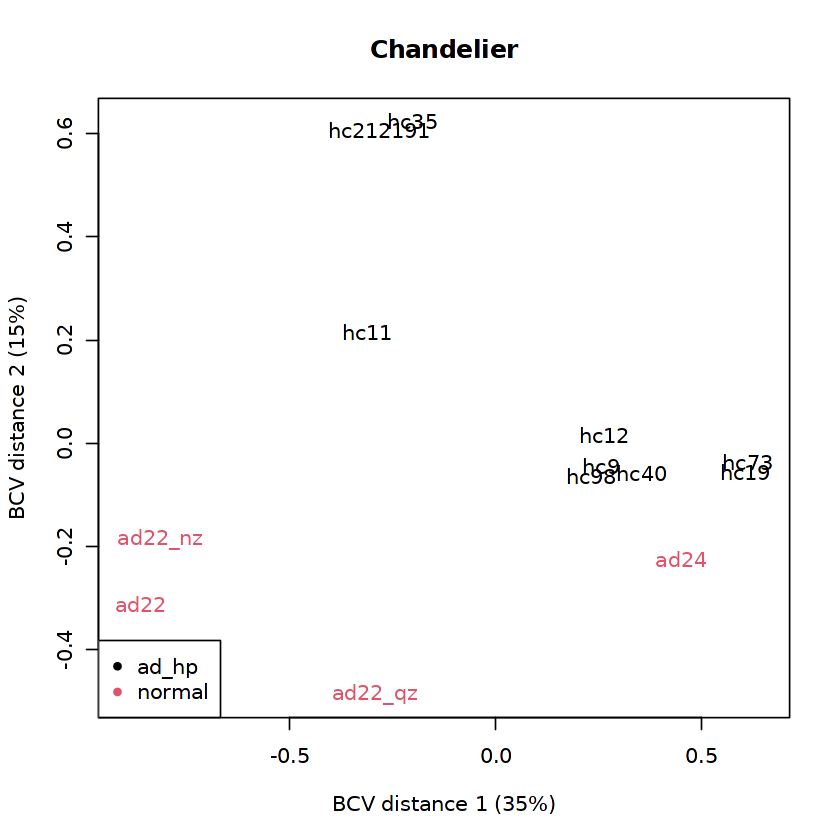

[1] "SUB"


Removing 4373 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



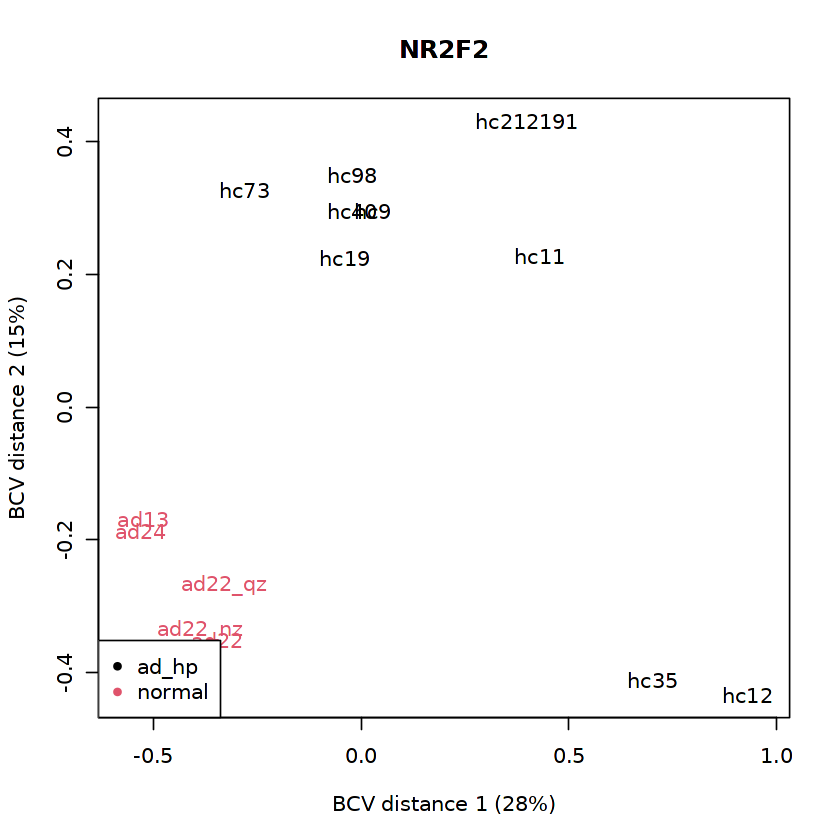

[1] "T-Cell"


Removing 23353 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



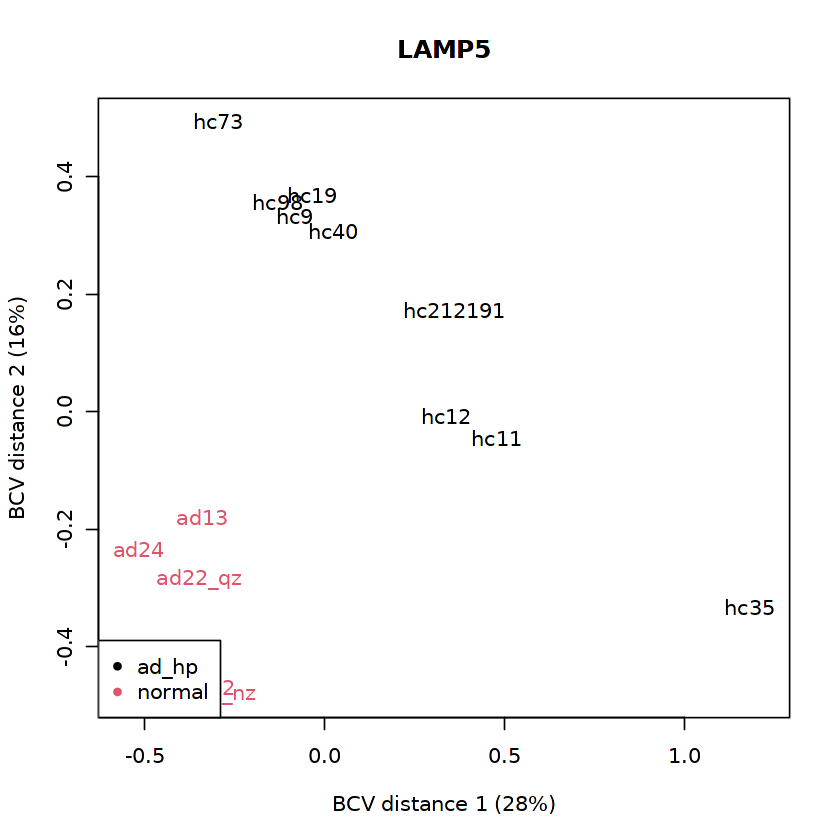

[1] "VLMC"


Removing 19392 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



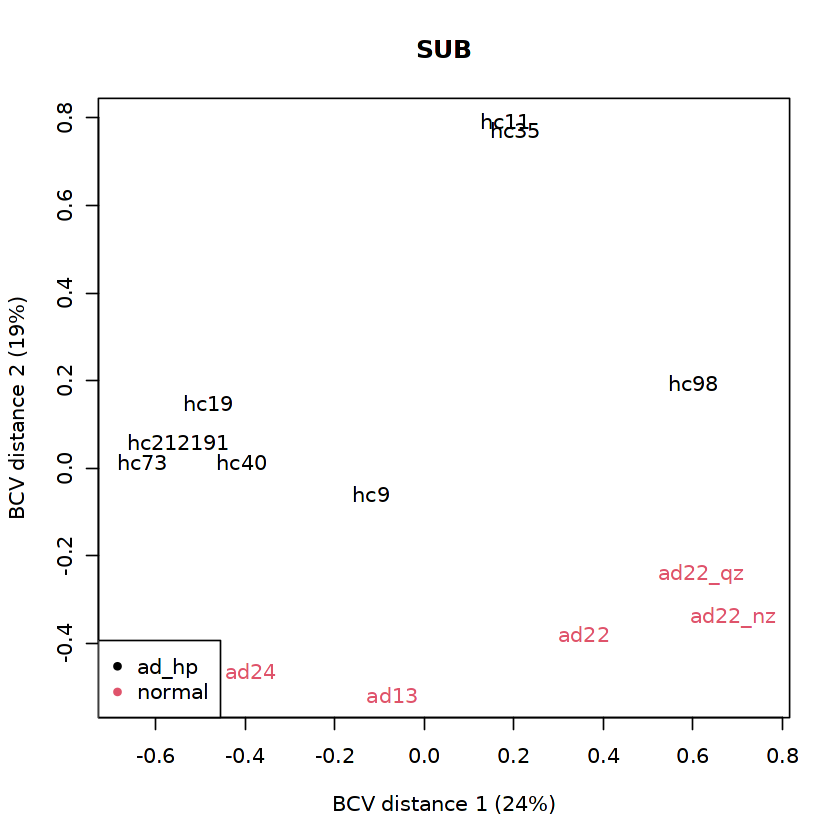

[1] "Endo"


Removing 19131 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



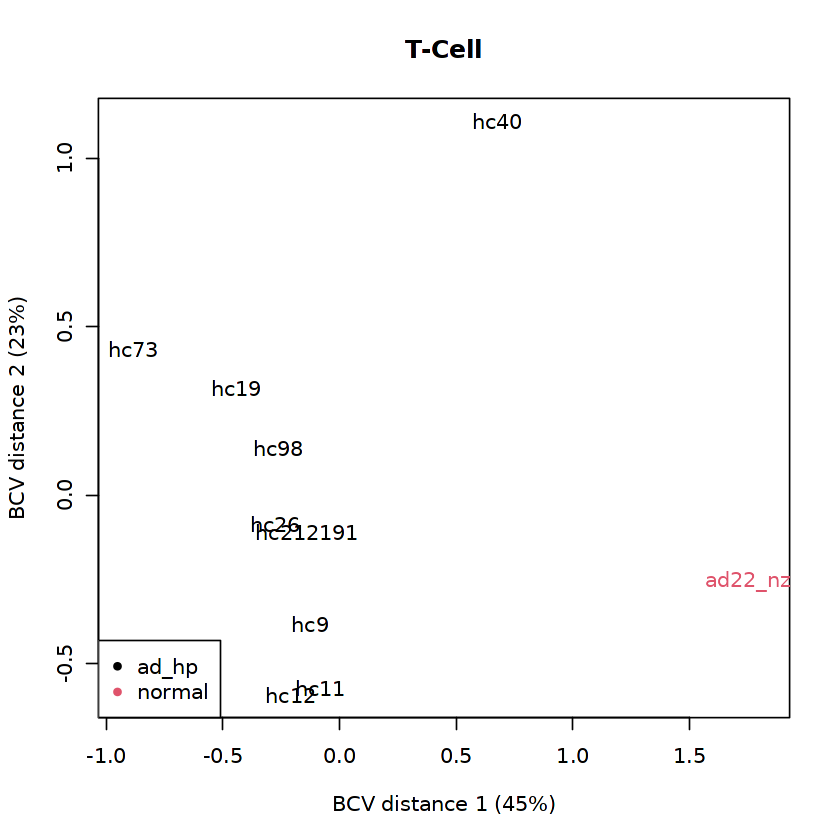

[1] "CA1"
[1] "DG"


Removing 9519 rows with all zero counts

Warning message in filterByExpr.DGEList(curr_dge, min.count = 5, min.prop = 0.5):
“All samples appear to belong to the same group.”
Note: the bcv method is now scheduled to be removed in a future release of edgeR.



ERROR: Error in plotMDS.DGEList(curr_dge, method = "bcv", col = as.numeric(curr_dge$samples$group)): Need at least 3 columns of data


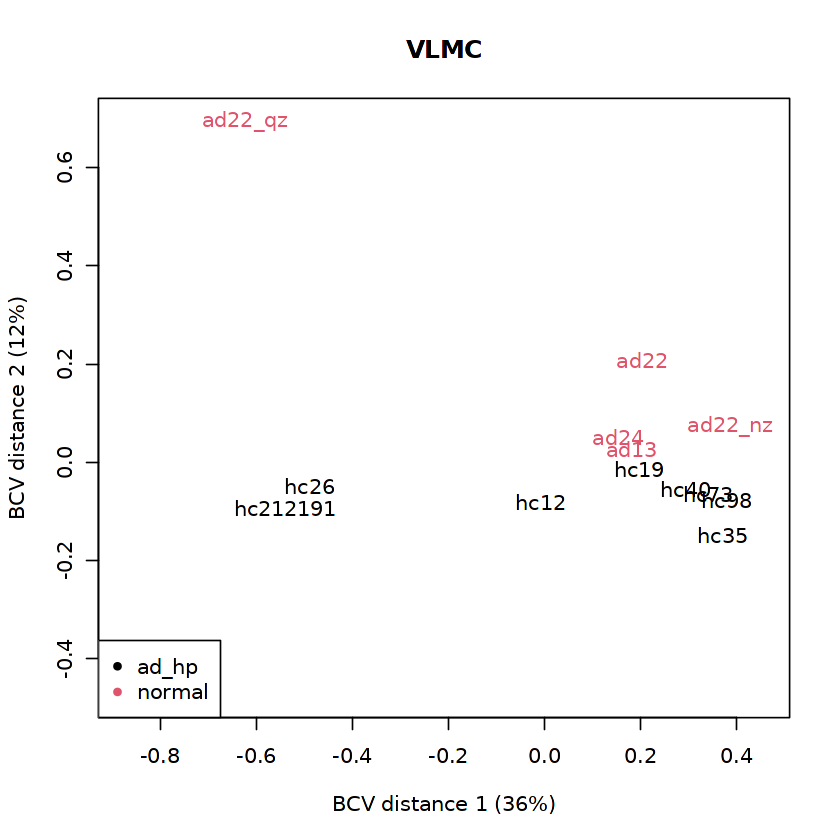

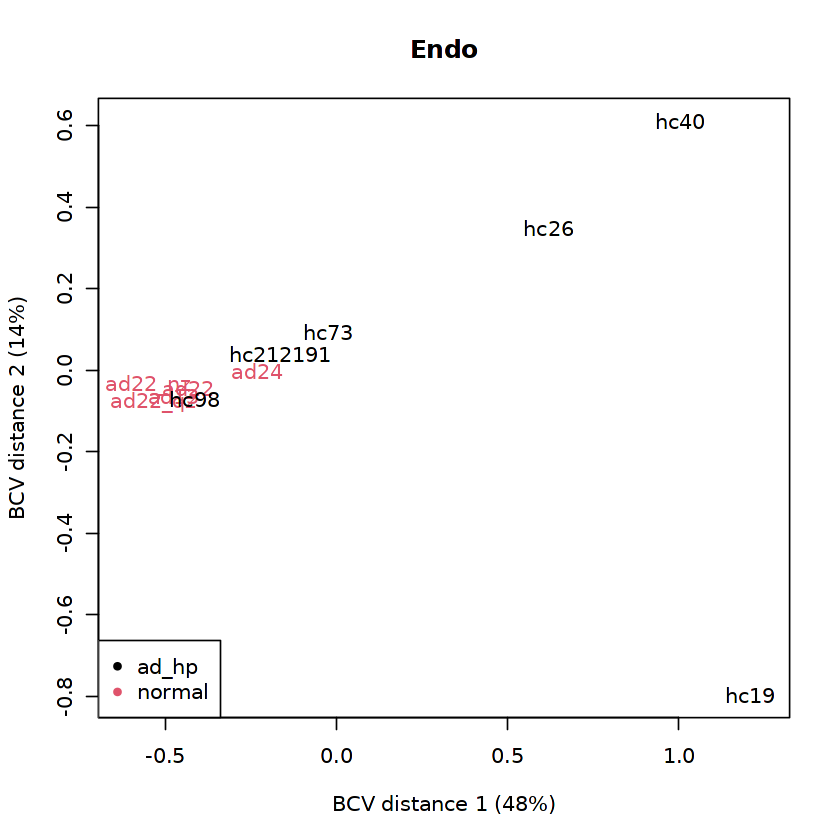

In [48]:
for (cluster in unique(se_object$celltype)) {
    suppressPackageStartupMessages({
        library(scran)
        library(scater)
    })
    print(cluster)
    flush.console()
    curr_object <- se_object[, se_object$celltype == cluster]
    if (ncol(curr_object) < 10) {
        next
    }
    curr_counts <- LayerData(curr_object, layer = c("counts"))
    curr_meta <- curr_object@meta.data
    curr_sce <- SingleCellExperiment(assays = list(counts = curr_counts), colData = curr_meta)
    curr_sce$dataset <- factor(curr_sce$dataset, levels = c("normal", "ad_hp"))
    groups <- curr_sce$orig.ident
    if (length(unique(groups)) < 2) {
        next
    }
    curr_aggr <- aggregateAcrossCells(curr_sce, groups, store.number = "group.size")
    
    curr_dge <- DGEList(counts = counts(curr_aggr), group = curr_aggr$dataset, remove.zeros = TRUE)
    keep <- filterByExpr(curr_dge, min.count = 5, min.prop = 0.5)
    curr_dge <- curr_dge[keep, , keep.lib.sizes=FALSE]
    curr_dge <- calcNormFactors(curr_dge, method = "TMM")
    
    detach("package:scran", unload = TRUE)
    detach("package:scater", unload = TRUE)
    plotMDS(curr_dge, method="bcv", col=as.numeric(curr_dge$samples$group))
    legend("bottomleft", as.character(unique(curr_dge$samples$group)), col=1:2, pch=20)
    title(main = cluster)
    
    curr_design <- model.matrix(~ 0 + curr_aggr$dataset)
    colnames(curr_design) <- levels(curr_aggr$dataset)
    curr_dge <- estimateDisp(curr_dge, curr_design, robust = TRUE)
    curr_fit <- glmQLFit(curr_dge, curr_design)
    curr_glf <- glmQLFTest(curr_fit, contrast = c(-1, 1))
    
    write.table(
        topTags(curr_glf, n = Inf)$table, 
        file.path("DGE_humanAD_jeff/", paste0(cluster, ".result.tsv")), 
        row.names = TRUE,
        col.names = TRUE,
        quote = FALSE,
        sep = "\t"
    )
}

## Cell level correspondance

In [58]:
split_and_concat <- function(x) {
    parts <- strsplit(x, "_")[[1]]
    paste(parts[1], parts[3], sep = "_")
}

split_and_concat2 <- function(x) {
    parts <- strsplit(x, "_")[[1]]
    paste(parts[1], "deep", parts[2], sep = "_")
}

In [59]:
micro_names <- as.vector(sapply(colnames(
    micro_sce[, micro_sce$dataset == "normal"]), split_and_concat))
length(micro_names)
syl_micro_names <- colnames(syl_micro_sce[, syl_micro_sce$group == "Normal"])
length(syl_micro_names)
syl_extra_names <- setdiff(syl_micro_names, micro_names)
length(syl_extra_names)
micro_extra_names <- sapply(syl_extra_names, split_and_concat2)

[1] 4093

[1] 3902

[1] 789

In [60]:
table(se_object$celltype[micro_extra_names], useNA = "ifany")


  Endo  Macro  Oligo T-Cell   <NA> 
     1     68     11     19    690 

In [61]:
rowSums(counts(syl_micro_sce)[top, syl_extra_names])

PEX5L     NLGN1  IL1RAPL1       AK5     GPM6B    NKAIN2     CDH20     AMER2 
     6110      7572     38064      2271      6635     10903      3395      1835 
    NCAM2     PTPRK   SLC24A2     NCAM1     LSAMP     PCDH9     MAGI2    SPOCK3 
    15613      7219      9755      4833      4258     60674     15848      7901 
   ADGRL3  CACNA2D1      QDPR     TTLL7     PTPRD    SPOCK1     EDIL3      GRM3 
     2366      2458      1957      8446     11853      6756      9907      3252 
   DNAJC6     ENOX1     NOVA1     FBXL7   PPP2R2B    CTNND2   PHYHIPL    ZNF536 
     4825      2991      1769      3474     18125      2748      1619      4003 
  GALNT13   PPP1R9A     ITGB8    GPRC5B  C10orf90      NFIB   SLCO1A2     SGIP1 
     1817      1642      1026      1884      3734      1149      2779      1251 
    CADM2   DSCAML1   PHACTR3    TMEFF2    PPFIA2      FIGN      MAP7      CLMN 
    17323      1748      1935      3676      2062      1158      7240      2500 
    MDGA2 LINC01608 
      599      4374

In [62]:
rowSums(counts(syl_micro_sce)[top, intersect(micro_names, syl_micro_names)])

PEX5L     NLGN1  IL1RAPL1       AK5     GPM6B    NKAIN2     CDH20     AMER2 
       84        83       262        46       268       128        25        42 
    NCAM2     PTPRK   SLC24A2     NCAM1     LSAMP     PCDH9     MAGI2    SPOCK3 
      208        46       113        83       119       609       179        85 
   ADGRL3  CACNA2D1      QDPR     TTLL7     PTPRD    SPOCK1     EDIL3      GRM3 
       56        42       202        95       151        98       169        43 
   DNAJC6     ENOX1     NOVA1     FBXL7   PPP2R2B    CTNND2   PHYHIPL    ZNF536 
       79        29        34        28       164        94        32        59 
  GALNT13   PPP1R9A     ITGB8    GPRC5B  C10orf90      NFIB   SLCO1A2     SGIP1 
       16        28        45        94        26        34        34        16 
    CADM2   DSCAML1   PHACTR3    TMEFF2    PPFIA2      FIGN      MAP7      CLMN 
      289        24        34        36        65        12       130        35 
    MDGA2 LINC01608 
       26        32

In [63]:
Idents(syl_object) <- "cluster"

In [69]:
syl_object_extra <- syl_object[, syl_extra_names]

In [70]:
syl_object_extra

An object of class Seurat 
72970 features across 789 samples within 2 assays 
Active assay: RNA (36485 features, 1990 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: sketch
 5 dimensional reductions calculated: pca, umap, pca.full, full.umap, full.umap.1

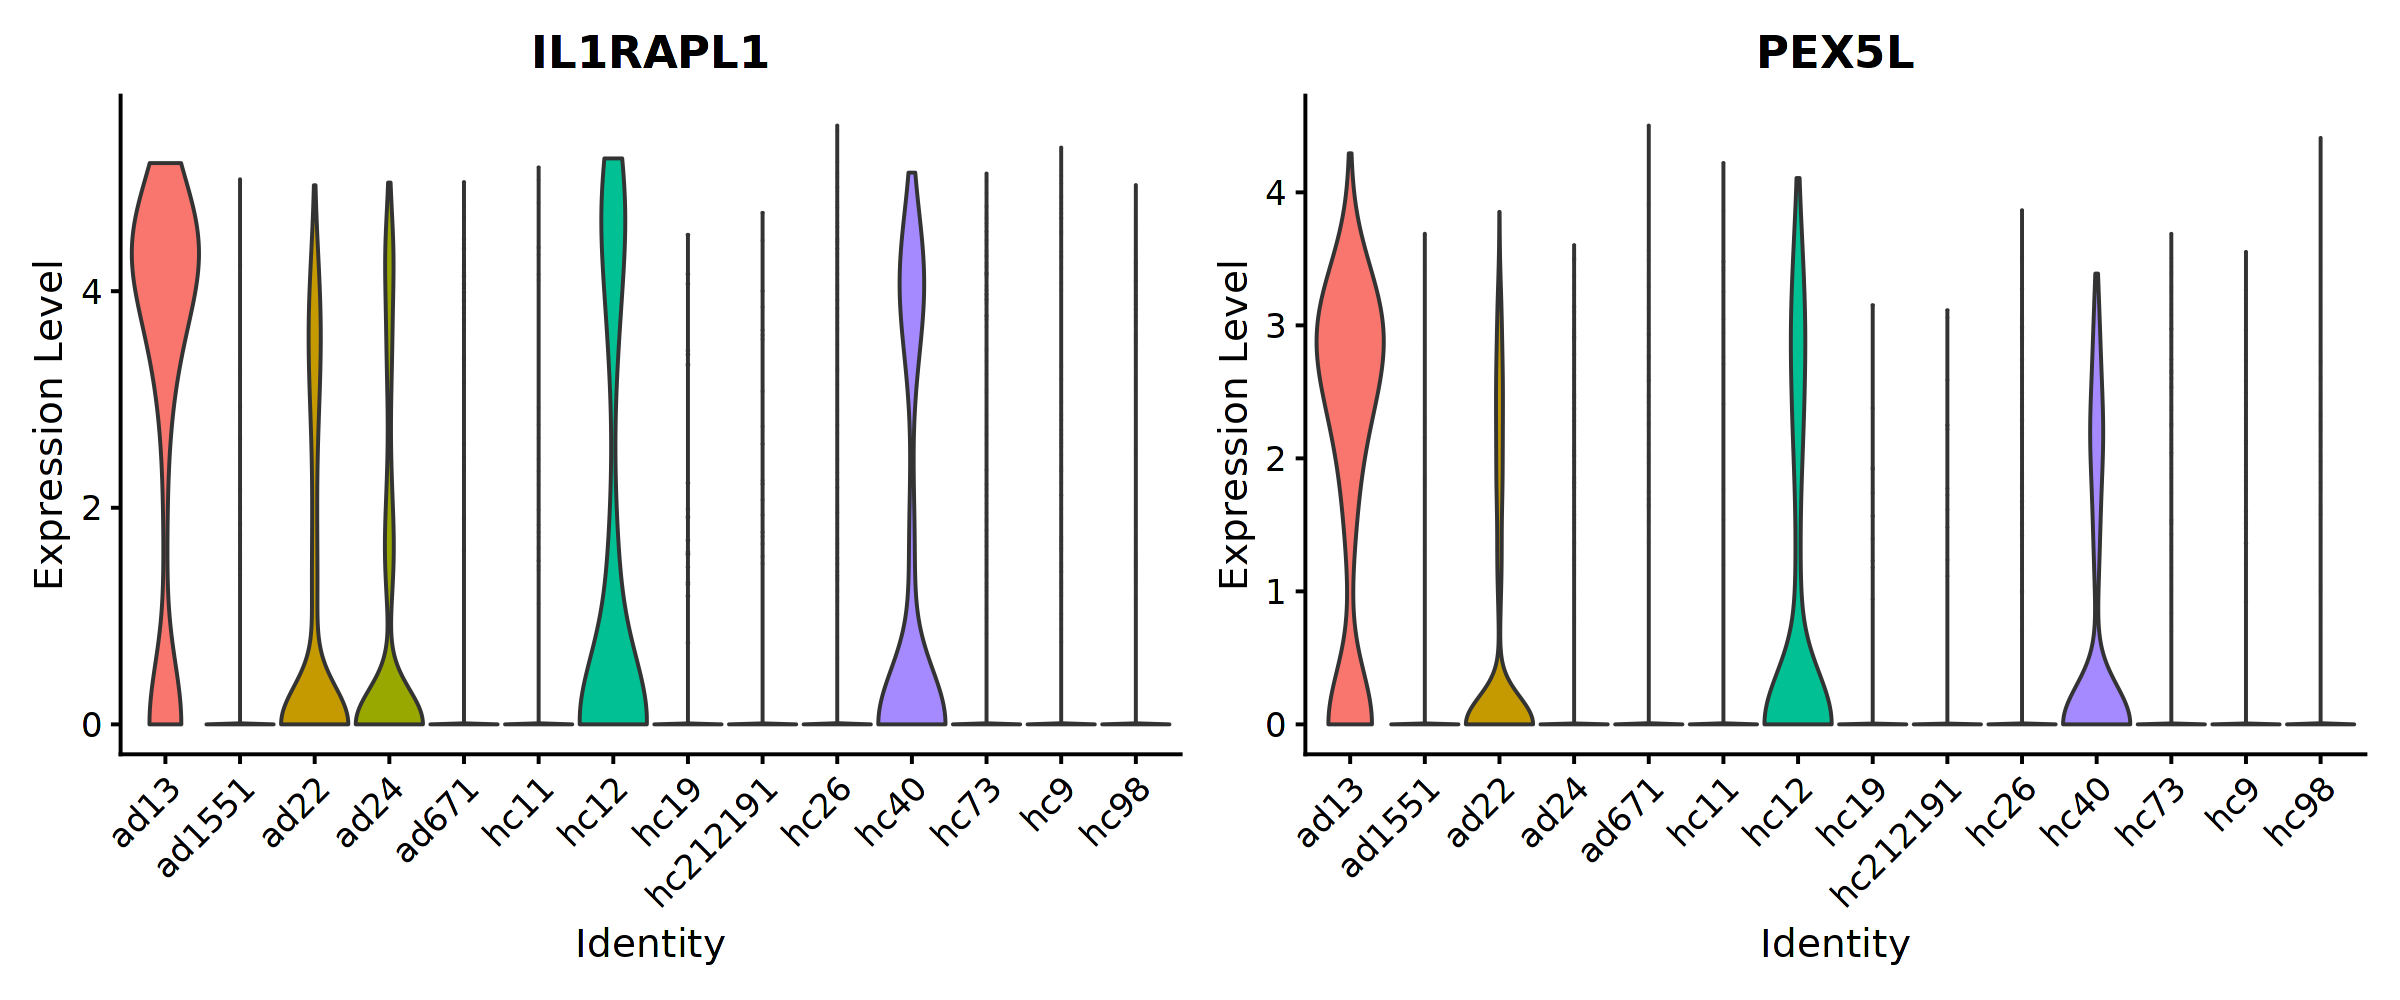

In [74]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
VlnPlot(
    syl_object,
    features = c('IL1RAPL1', 'PEX5L'),
    cols = NULL,
    pt.size = 0,
    alpha = 1,
    idents = 'Microglia',
    sort = FALSE,
    assay = NULL,
    group.by = 'donor',
    layer = 'data'
)

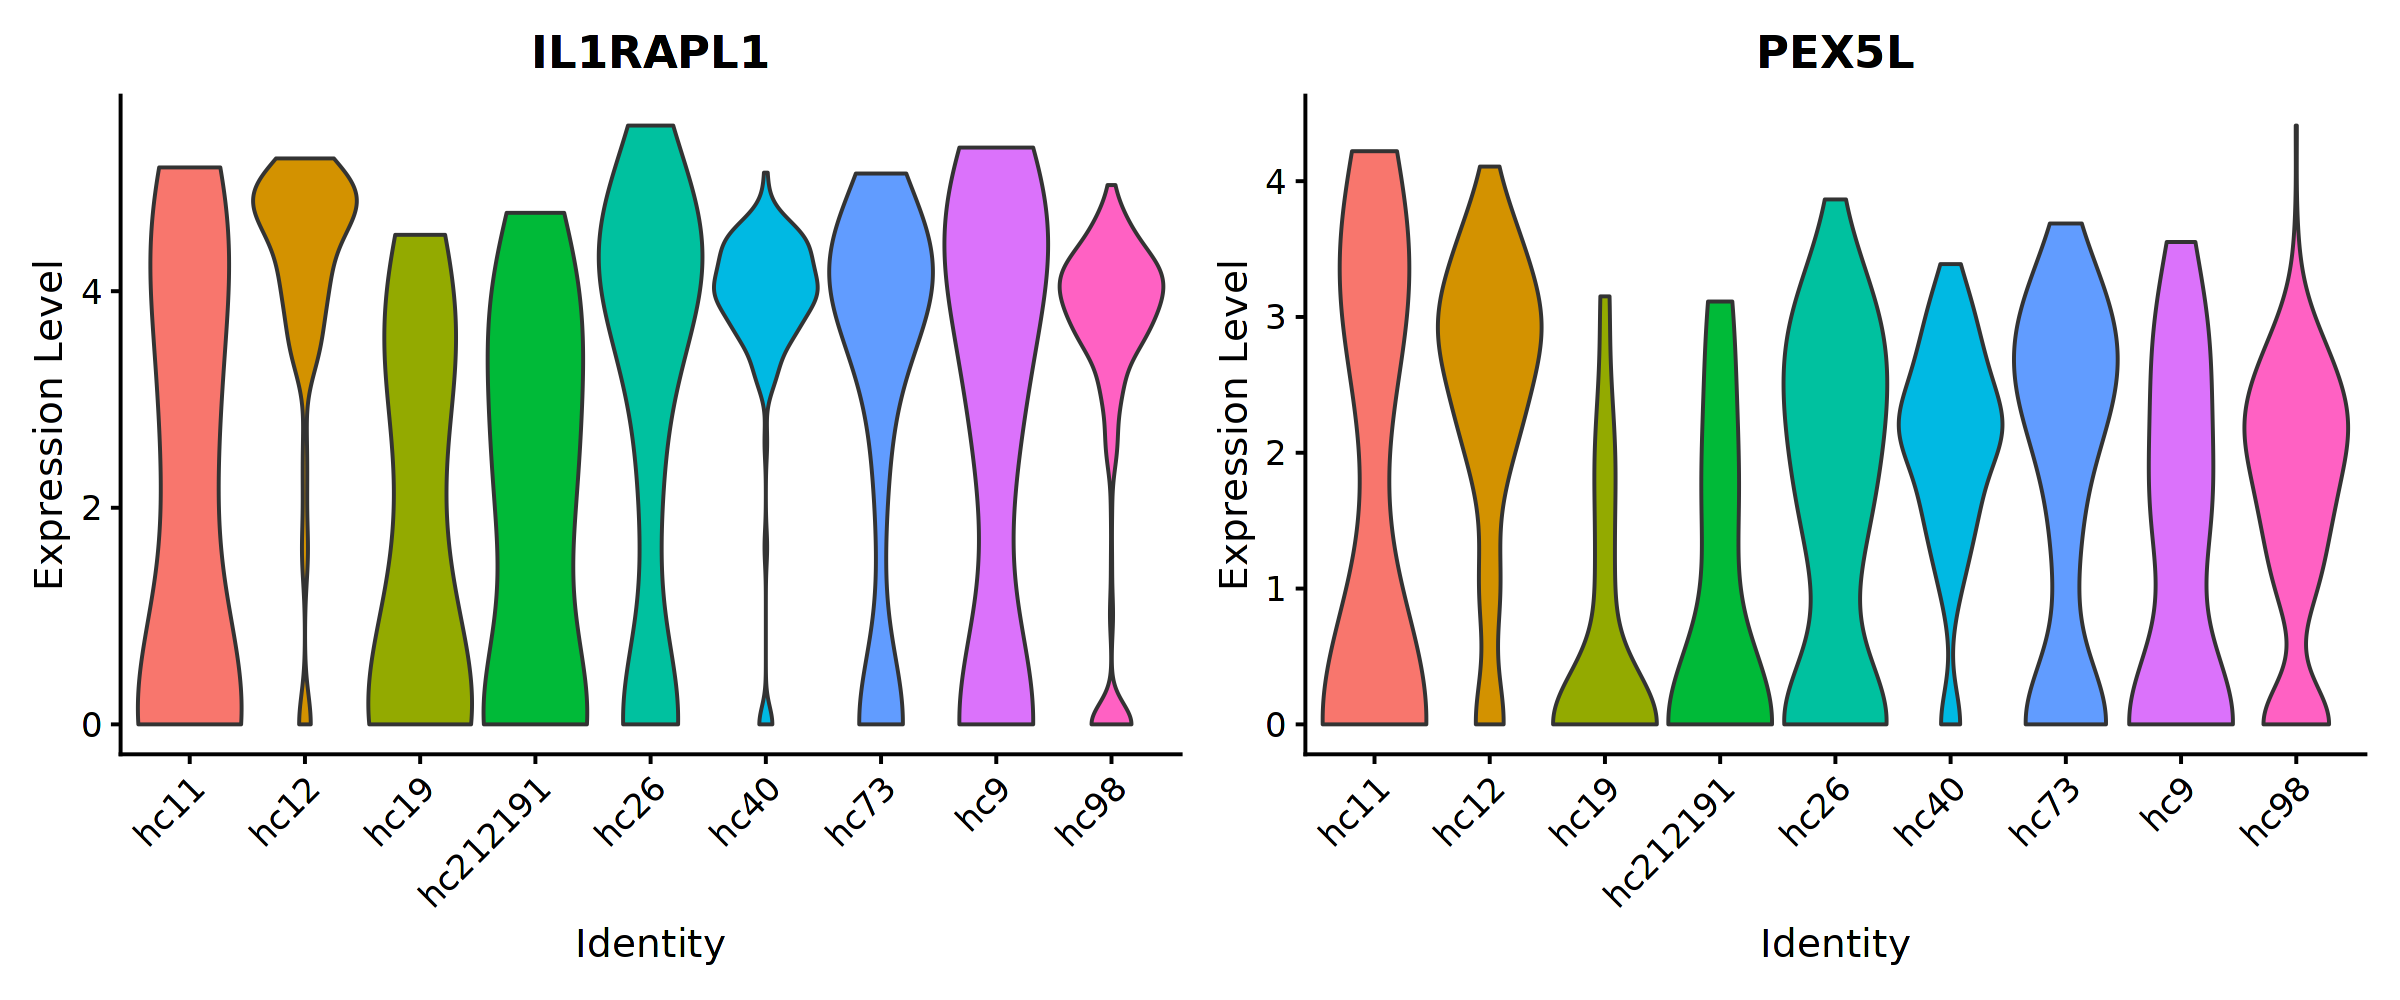

In [75]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
VlnPlot(
    syl_object_extra,
    features = c('IL1RAPL1', 'PEX5L'),
    cols = NULL,
    pt.size = 0,
    alpha = 1,
    idents = 'Microglia',
    sort = FALSE,
    assay = NULL,
    group.by = 'donor',
    layer = 'data'
)

In [54]:
micro_names <- colnames(micro_sce[, micro_sce$dataset == "ad_hp"])
syl_micro_names <- colnames(syl_micro_sce[, syl_micro_sce$group == "AD"])
length(micro_names)
length(syl_micro_names)
syl_extra_names <- setdiff(syl_micro_names, micro_names)
length(syl_extra_names)

[1] 1775

[1] 2746

[1] 2097

In [55]:
table(se_object$celltype[syl_extra_names], useNA = "ifany")


Macro   SST   VIP  <NA> 
    3     1     1  2092 

In [56]:
rowSums(counts(syl_micro_sce)[top, syl_extra_names])

PEX5L     NLGN1  IL1RAPL1       AK5     GPM6B    NKAIN2     CDH20     AMER2 
     4944      4775     19826      1604      4979      6388      2941      1362 
    NCAM2     PTPRK   SLC24A2     NCAM1     LSAMP     PCDH9     MAGI2    SPOCK3 
    11148      4234      5682      3604      2893     34751     10003      4962 
   ADGRL3  CACNA2D1      QDPR     TTLL7     PTPRD    SPOCK1     EDIL3      GRM3 
     2340      1419      2475      4575      6697      3687      5818      2385 
   DNAJC6     ENOX1     NOVA1     FBXL7   PPP2R2B    CTNND2   PHYHIPL    ZNF536 
     2963      1783      1309      2193      7824      1652       865      2398 
  GALNT13   PPP1R9A     ITGB8    GPRC5B  C10orf90      NFIB   SLCO1A2     SGIP1 
      946      1096       764      1533      2446       727      1646       947 
    CADM2   DSCAML1   PHACTR3    TMEFF2    PPFIA2      FIGN      MAP7      CLMN 
    12248      1382      1101      2006      1319       801      4811      1516 
    MDGA2 LINC01608 
     1030      2265

In [57]:
rowSums(counts(syl_micro_sce)[top, intersect(micro_names, syl_micro_names)])

PEX5L     NLGN1  IL1RAPL1       AK5     GPM6B    NKAIN2     CDH20     AMER2 
     1598      1497      7416       619      1307      2231       981       407 
    NCAM2     PTPRK   SLC24A2     NCAM1     LSAMP     PCDH9     MAGI2    SPOCK3 
     3547      1219      2079      1115      1086     11207      3424      1737 
   ADGRL3  CACNA2D1      QDPR     TTLL7     PTPRD    SPOCK1     EDIL3      GRM3 
      732       488       594      1439      2359      1188      1903       885 
   DNAJC6     ENOX1     NOVA1     FBXL7   PPP2R2B    CTNND2   PHYHIPL    ZNF536 
      991       669       420       830      2783       525       287       799 
  GALNT13   PPP1R9A     ITGB8    GPRC5B  C10orf90      NFIB   SLCO1A2     SGIP1 
      408       364       210       441       792       210       545       314 
    CADM2   DSCAML1   PHACTR3    TMEFF2    PPFIA2      FIGN      MAP7      CLMN 
     3592       436       400       730       387       298      1507       453 
    MDGA2 LINC01608 
      215       909

## New object

In [76]:
syl_micro_new <- readRDS("humanAD_seurat_Microglia.rds")

In [84]:
syl_micro_new <- syl_micro_new[, syl_micro_new$group != "HighPathology"]

[1] "Microglia"


Removing 9287 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



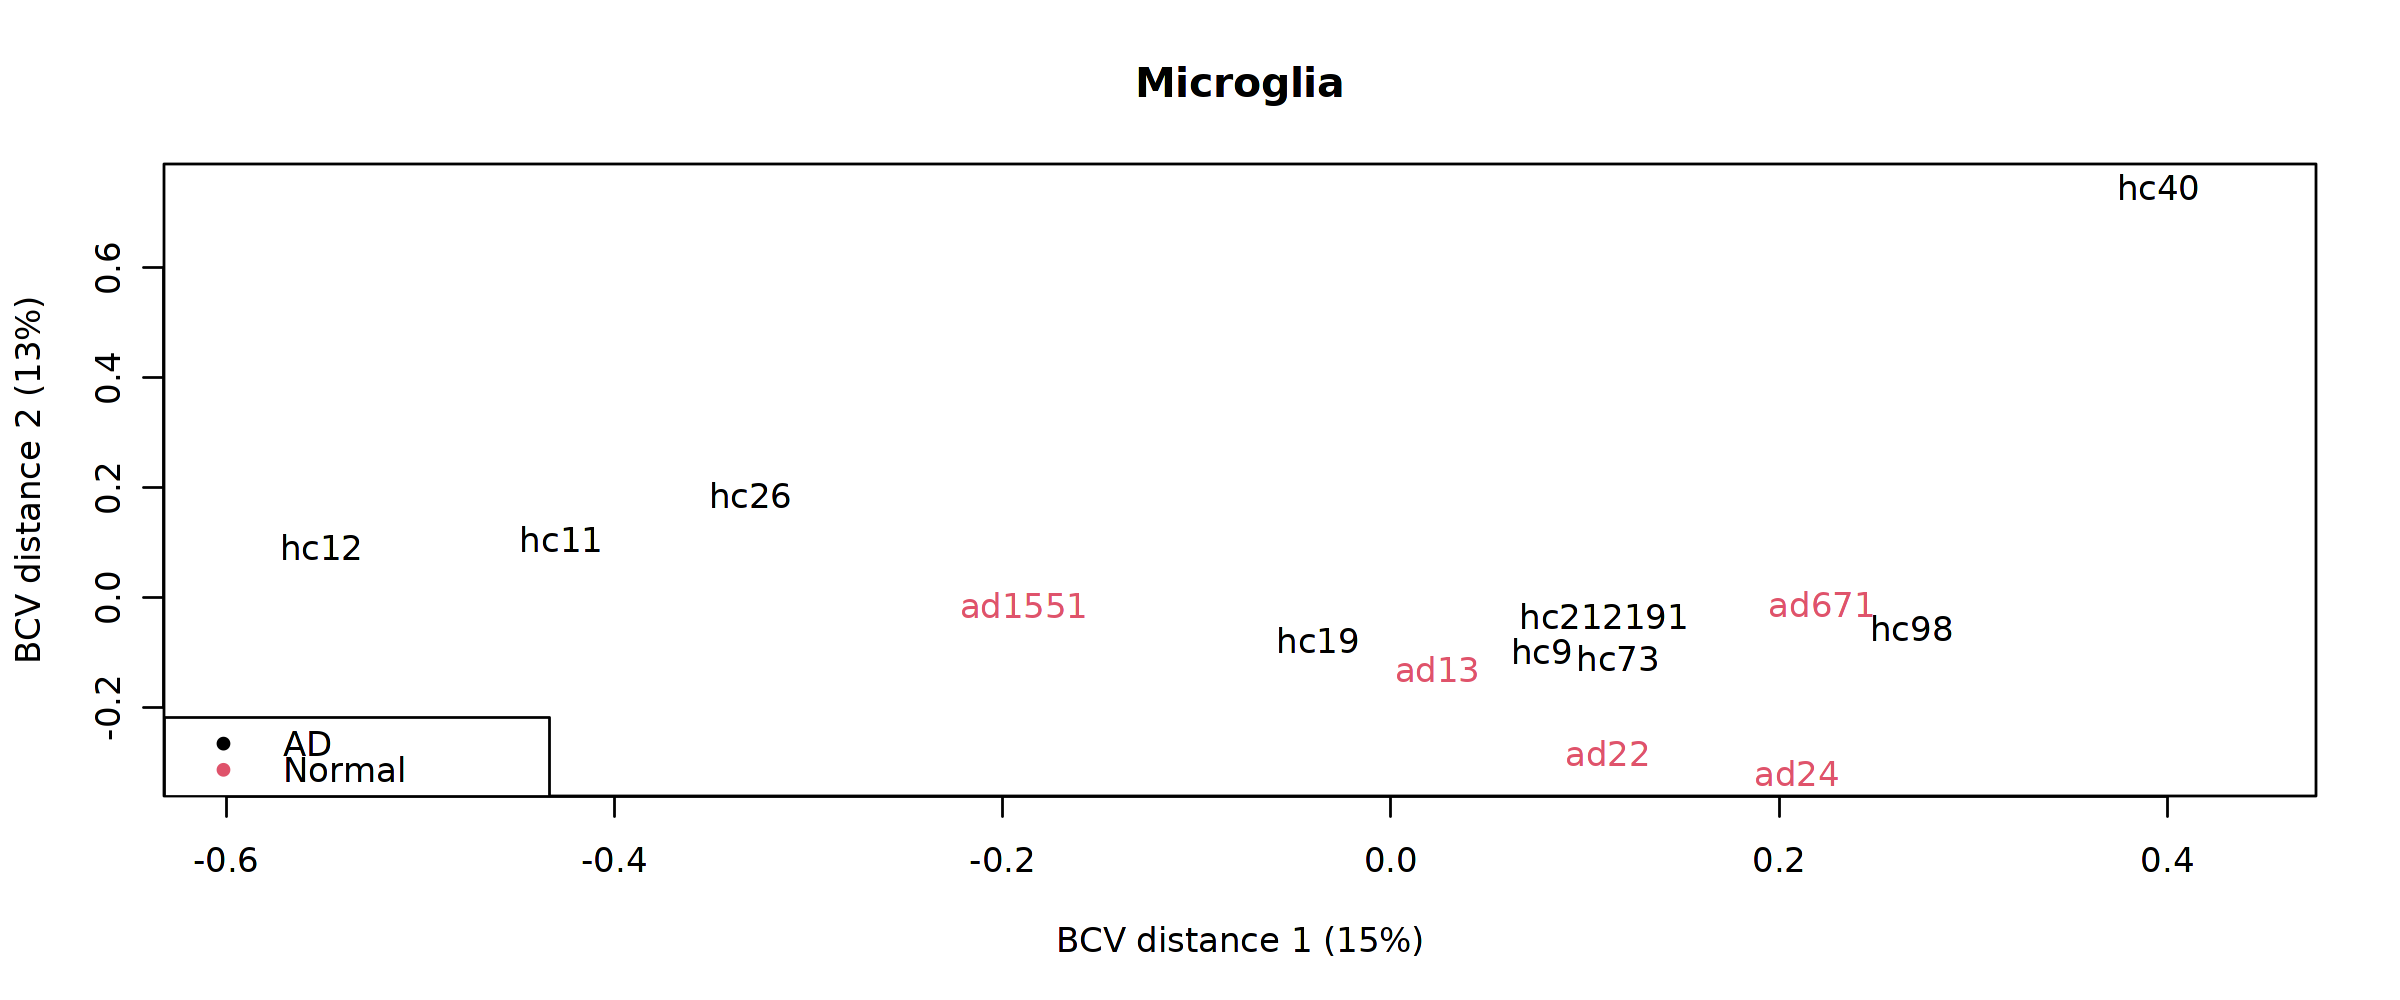

In [85]:
for (cluster in unique(syl_micro_new$cluster)) {
    suppressPackageStartupMessages({
        library(scran)
        library(scater)
    })
    print(cluster)
    flush.console()
    curr_object <- syl_micro_new[, syl_micro_new$cluster == cluster]
    if (ncol(curr_object) < 10) {
        next
    }
    curr_counts <- LayerData(curr_object, layer = c("counts"))
    curr_meta <- curr_object@meta.data
    curr_sce <- SingleCellExperiment(assays = list(counts = curr_counts), colData = curr_meta)
    curr_sce$group <- factor(curr_sce$group, levels = c("Normal", "AD"))
    groups <- curr_sce$donor
    if (length(unique(groups)) < 2) {
        next
    }
    curr_aggr <- aggregateAcrossCells(curr_sce, groups, store.number = "group.size")
    
    curr_dge <- DGEList(counts = counts(curr_aggr), group = curr_aggr$group, remove.zeros = TRUE)
    keep <- filterByExpr(curr_dge, min.count = 5, min.prop = 0.5)
    curr_dge <- curr_dge[keep, , keep.lib.sizes=FALSE]
    curr_dge <- calcNormFactors(curr_dge, method = "TMM")
    
    detach("package:scran", unload = TRUE)
    detach("package:scater", unload = TRUE)
    plotMDS(curr_dge, method="bcv", col=as.numeric(curr_dge$samples$group))
    legend("bottomleft", as.character(unique(curr_dge$samples$group)), col=1:2, pch=20)
    title(main = cluster)
    
    curr_design <- model.matrix(~ 0 + curr_aggr$group)
    colnames(curr_design) <- levels(curr_aggr$group)
    curr_dge <- estimateDisp(curr_dge, curr_design, robust = TRUE)
    curr_fit <- glmQLFit(curr_dge, curr_design)
    curr_glf <- glmQLFTest(curr_fit, contrast = c(-1, 1))
    
    write.table(
        topTags(curr_glf, n = Inf)$table, 
        file.path("DGE_humanAD_new/", paste0(cluster, ".result.tsv")), 
        row.names = TRUE,
        col.names = TRUE,
        quote = FALSE,
        sep = "\t"
    )
}

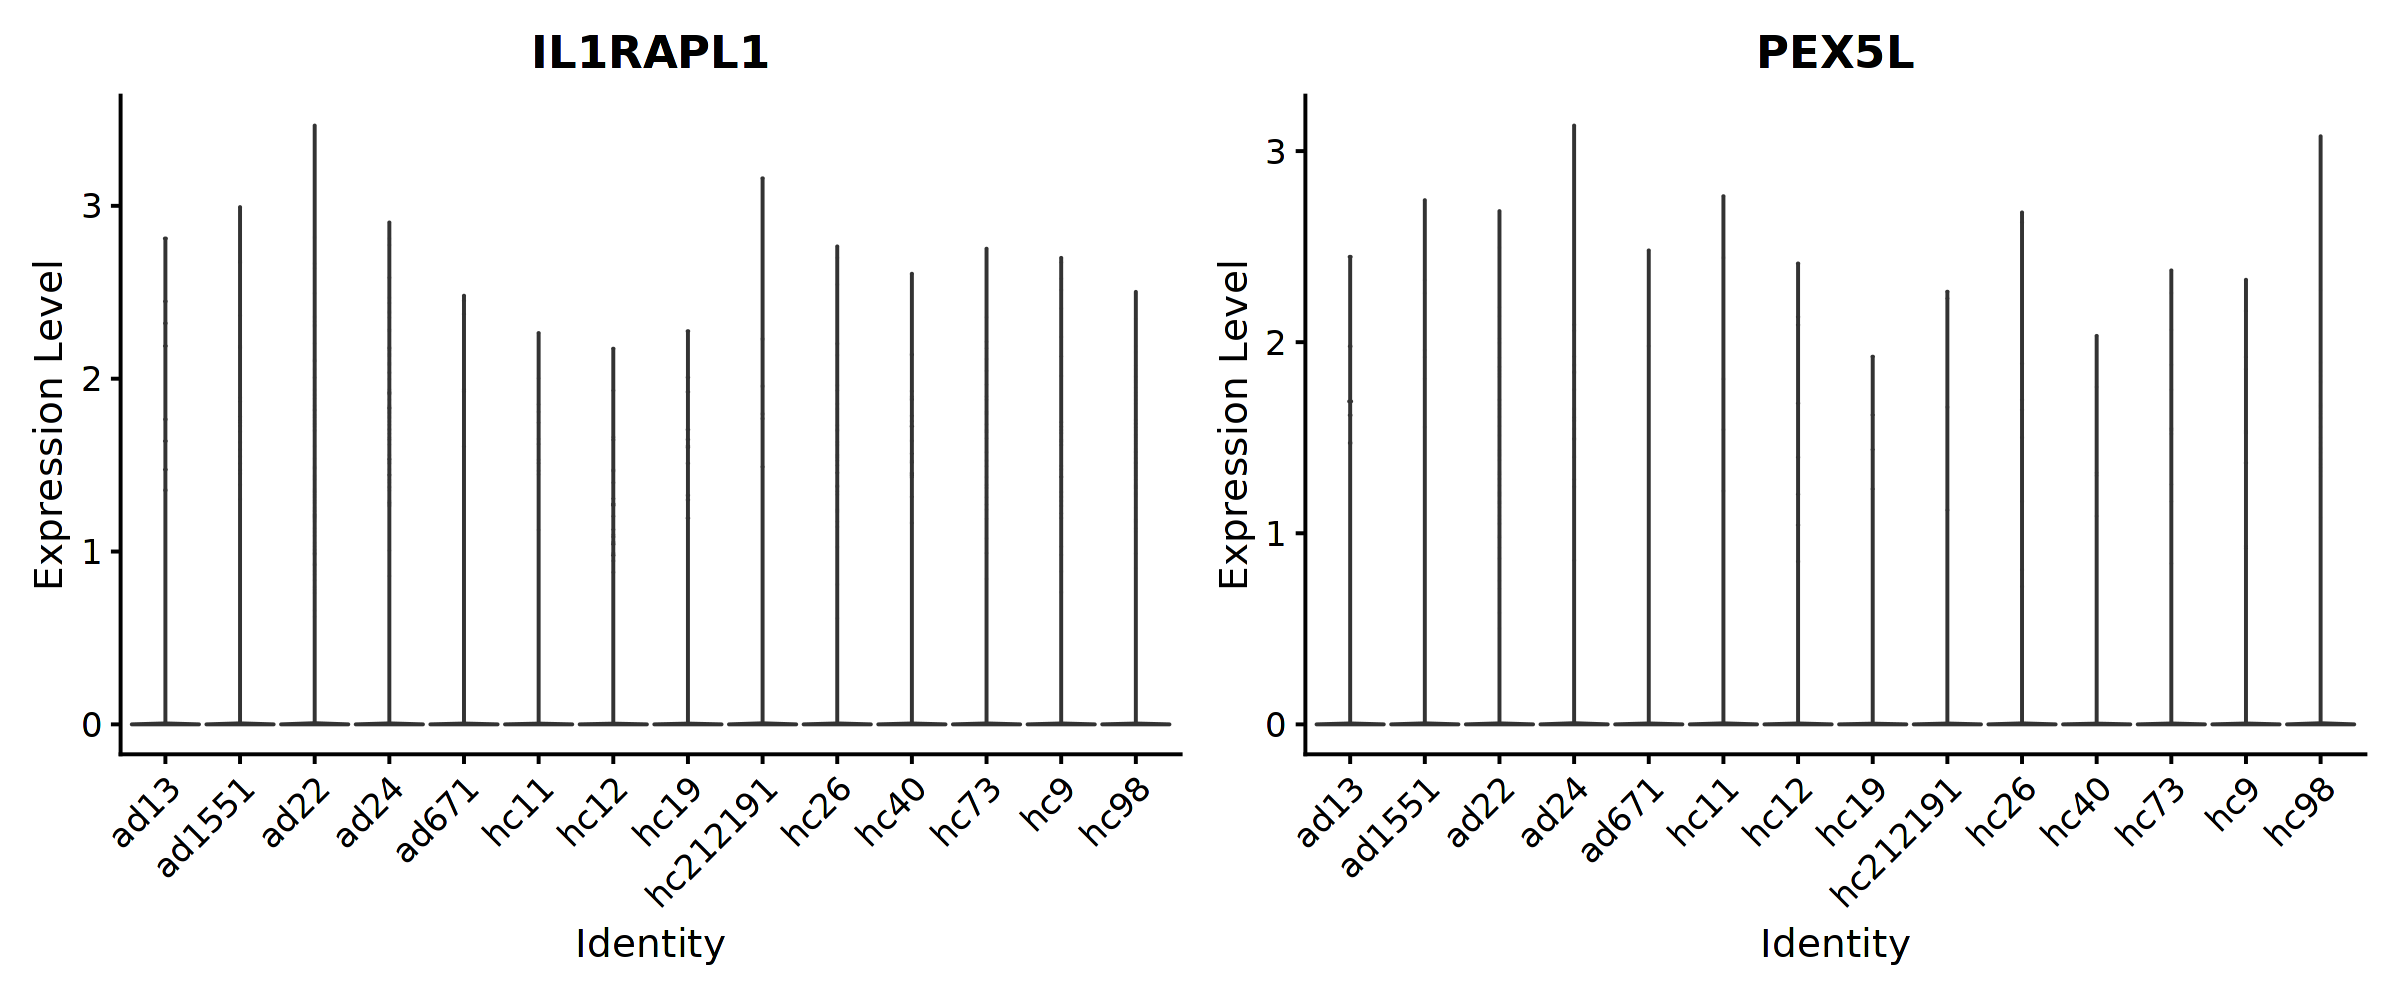

In [90]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
VlnPlot(
    syl_micro_new,
    features = c('IL1RAPL1', 'PEX5L'),
    cols = NULL,
    pt.size = 0,
    alpha = 1,
    # idents = 'Microglia',
    sort = FALSE,
    assay = NULL,
    group.by = 'donor',
    layer = 'data'
)

In [92]:
syl_micro_new_aggr <- AggregateExpression(syl_micro_new, slot = "counts", group.by = "donor")

In [95]:
colnames(syl_micro_new_aggr)

data[, 1]ad13   data[, 1]ad1551     data[, 1]ad22     data[, 1]ad24 
           "ad13"          "ad1551"            "ad22"            "ad24" 
   data[, 1]ad671     data[, 1]hc11     data[, 1]hc12     data[, 1]hc19 
          "ad671"            "hc11"            "hc12"            "hc19" 
data[, 1]hc212191     data[, 1]hc26     data[, 1]hc40     data[, 1]hc73 
       "hc212191"            "hc26"            "hc40"            "hc73" 
     data[, 1]hc9     data[, 1]hc98 
            "hc9"            "hc98"

In [96]:
syl_micro_new_aggr["SERPINE1", ]

ad13   ad1551     ad22     ad24    ad671     hc11     hc12     hc19 
       9       57       19        3       68        1        9       12 
hc212191     hc26     hc40     hc73      hc9     hc98 
      31      558      262        6      198     2443